## Comparing Political Discourse in Great Britain, Austria, and Croatia

### Research Questions (aligned with paper):
1. **Cross-Country Differences**: How do countries differ in their linguistic approach to political topics?
2. **Focal Topic Analysis**: How does macroeconomics differ linguistically from other policy domains?
3. **Political Covariates**: How do party status, orientation, gender, and age shape linguistic style?
4. **Temporal Evolution**: What are the trends in political language over time (with event annotations)?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr, f_oneway
from itertools import combinations
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14
})
pd.set_option('display.max_columns', None)

# Create output directory for paper figures
output_dir = r"C:\Users\pavle\OneDrive\Desktop\my github\master-thesis\figures"
os.makedirs(output_dir, exist_ok=True)

# Data paths
GB_path = r"data folder\GB\GB_final.pkl"
AT_path = r"data folder\AT\AT_final.pkl"
HR_path = r"data folder\HR\HR_final.pkl"

GB_path_LIWC = r"data folder\GB\GB_LIWC_results.csv"
AT_path_LIWC = r"data folder\AT\AT_LIWC_results.csv"
HR_path_LIWC = r"data folder\HR\HR_LIWC_results.csv"

LIWC_statistics_path = r"data folder\data\LIWC-22.Descriptive.Statistics-Test.Kitchen.xlsx"

# Define key LIWC dimensions focused on political discourse
KEY_LIWC_DIMENSIONS = [
    'Analytic', 'Clout', 'Authentic',  # Summary variables
    'i', 'we', 'you', 'shehe', 'they', 'ipron', 'ppron',  # Personal pronouns
    'focuspast', 'focuspresent', 'focusfuture',  # Time orientation
    'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certitude',  # Cognitive processes
    'Tone', 'Affect', 'tone_pos', 'tone_neg',  # Emotion
    'Social', 'conflict', 'moral', # Social
    'power', 'politic',  'money', 'work'  # Social & political
]

# Extract LIWC Total benchmarks (overall population norms)
def load_liwc_total_benchmarks(file_path):
    """Load LIWC-22 Total benchmarks - overall population norms"""
    raw_data = pd.read_excel(file_path, sheet_name=0, header=None)
    
    # Find "Total" in the first row
    header_row = raw_data.iloc[0]
    total_col_start = [i for i, val in enumerate(header_row) if str(val).strip() == 'Total'][0]
    
    # Extract dimensions and statistics
    dimensions = raw_data.iloc[2:, 0].dropna().reset_index(drop=True)
    total_mean = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start], errors='coerce')
    total_std = pd.to_numeric(raw_data.iloc[2:2+len(dimensions), total_col_start+1], errors='coerce')
    
    # Create benchmark dataframe
    benchmarks = pd.DataFrame({
        'Dimension': dimensions,
        'Mean': total_mean.values,
        'Std': total_std.values
    })
    
    return benchmarks.dropna().reset_index(drop=True)

# Load parliamentary data
def load_parliamentary_data():
    """Load and merge parliamentary datasets"""W
    print("Loading datasets...")
    
    # Load data
    AT = pd.read_pickle(AT_path)
    HR = pd.read_pickle(HR_path)
    GB = pd.read_pickle(GB_path)

    AT_LIWC = pd.read_csv(AT_path_LIWC)
    HR_LIWC = pd.read_csv(HR_path_LIWC)
    GB_LIWC = pd.read_csv(GB_path_LIWC)

    # Merge datasets
    AT = pd.merge(AT, AT_LIWC, on='ID', how='inner')
    HR = pd.merge(HR, HR_LIWC, on='ID', how='inner')
    GB = pd.merge(GB, GB_LIWC, on='ID', how='inner')

    # Add country identifiers
    AT['Country'] = 'Austria'
    HR['Country'] = 'Croatia'
    GB['Country'] = 'Great Britain'

    # Combine datasets
    LIWC_ALL = pd.concat([AT, HR, GB], ignore_index=True)

    # Process dates and add year column
    LIWC_ALL['Date'] = pd.to_datetime(LIWC_ALL['Date'], errors='coerce')
    LIWC_ALL['Year'] = LIWC_ALL['Date'].dt.year

    # Rename columns for clarity
    LIWC_ALL.rename(columns={'topic_consensus': 'Our_Topic', 'Topic': 'ParlaCAP'}, inplace=True)

    # Filter out 'Mix' and 'Other' topics for cleaner analysis
    LIWC_ALL = LIWC_ALL[~LIWC_ALL['Our_Topic'].isin(['Mix', 'Other'])]
    
    # EXCLUDE CHAIRPERSON SPEECHES
    initial_count = len(LIWC_ALL)
    LIWC_ALL = LIWC_ALL[LIWC_ALL['Speaker_role'] != 'Chairperson']
    excluded_count = initial_count - len(LIWC_ALL)
    print(f"✓ Excluded {excluded_count:,} chairperson speeches")

    # Calculate Speaker_age from Speaker_birth and Year
    # Convert Speaker_birth to numeric, handling any non-numeric values
    LIWC_ALL['Speaker_birth'] = pd.to_numeric(LIWC_ALL['Speaker_birth'], errors='coerce')
    LIWC_ALL['Speaker_age'] = LIWC_ALL['Year'] - LIWC_ALL['Speaker_birth']
    
    print(f"✓ Combined dataset: {len(LIWC_ALL):,} speeches")
    print(f"✓ Topics: {len(LIWC_ALL['Our_Topic'].unique())} distinct topics")
    print(f"✓ Countries: {', '.join(LIWC_ALL['Country'].unique())}")
    
    return LIWC_ALL, AT, HR, GB

# Load benchmarks and parliamentary data
LIWC_benchmarks = load_liwc_total_benchmarks(LIWC_statistics_path)
LIWC_ALL, AT, HR, GB = load_parliamentary_data()

# Token Limit Analysis for BGE-M3 Model (8192 tokens)
print("\n" + "="*60)
print("BGE-M3 TOKEN LIMIT ANALYSIS (8192 tokens)")
print("="*60)

TOKEN_MULTIPLIER = 1.3
TOKEN_LIMIT = 8192

# Speech-level analysis
for country_name, country_data in [('Austria', AT), ('Croatia', HR), ('Great Britain', GB)]:
    country_data['Estimated_Tokens'] = country_data['WC'] * TOKEN_MULTIPLIER
    
    total_speeches = len(country_data)
    exceeds_limit = (country_data['Estimated_Tokens'] > TOKEN_LIMIT).sum()
    percentage = (exceeds_limit / total_speeches) * 100
    
    # Additional statistics
    mean_tokens = country_data['Estimated_Tokens'].mean()
    median_tokens = country_data['Estimated_Tokens'].median()
    max_tokens = country_data['Estimated_Tokens'].max()
    
    print(f"\n{country_name}:")
    print(f"  Total speeches: {total_speeches:,}")
    print(f"  Exceeding 8192 tokens: {exceeds_limit:,} ({percentage:.2f}%)")
    print(f"  Mean tokens: {mean_tokens:.0f}")
    print(f"  Median tokens: {median_tokens:.0f}")
    print(f"  Max tokens: {max_tokens:.0f}")

print("\n" + "="*60)
print("Note: Token estimate uses word count × 1.3 multiplier")
print("="*60)

# Segment-level analysis
print("\n" + "="*60)
print("SEGMENT-LEVEL TOKEN ANALYSIS")
print("="*60)
print("Analyzing segments using Segment_ID columns...")

for country_name, country_data in [('Austria', AT), ('Croatia', HR), ('Great Britain', GB)]:
    # Use appropriate segment ID column based on country
    if country_name in ['Austria', 'Croatia']:
        segment_col = 'Segment_ID_english'
    else:  # Great Britain
        segment_col = 'Segment_ID'
    
    # Check if column exists
    if segment_col not in country_data.columns:
        print(f"\n{country_name}: {segment_col} column not found, skipping...")
        continue
    
    # Calculate segment-level word counts and token estimates
    segment_wc = country_data.groupby(segment_col)['WC'].sum().reset_index()
    segment_wc['Estimated_Tokens'] = segment_wc['WC'] * TOKEN_MULTIPLIER
    
    total_segments = len(segment_wc)
    exceeds_limit = (segment_wc['Estimated_Tokens'] > TOKEN_LIMIT).sum()
    percentage = (exceeds_limit / total_segments) * 100
    
    # Additional statistics
    mean_tokens = segment_wc['Estimated_Tokens'].mean()
    median_tokens = segment_wc['Estimated_Tokens'].median()
    max_tokens = segment_wc['Estimated_Tokens'].max()
    
    print(f"\n{country_name}:")
    print(f"  Total segments: {total_segments:,}")
    print(f"  Exceeding 8192 tokens: {exceeds_limit:,} ({percentage:.2f}%)")
    print(f"  Mean tokens per segment: {mean_tokens:.0f}")
    print(f"  Median tokens per segment: {median_tokens:.0f}")
    print(f"  Max tokens per segment: {max_tokens:.0f}")

print("\n" + "="*60)
print("Note: Segments defined by Segment_ID_english (AT/HR) or Segment_ID (GB)")
print("="*60)

Loading datasets...
✓ Excluded 72,659 chairperson speeches
✓ Combined dataset: 819,579 speeches
✓ Topics: 21 distinct topics
✓ Excluded 72,659 chairperson speeches
✓ Combined dataset: 819,579 speeches
✓ Topics: 21 distinct topics
✓ Countries: Austria, Croatia, Great Britain

BGE-M3 TOKEN LIMIT ANALYSIS (8192 tokens)

Austria:
  Total speeches: 231,759
  Exceeding 8192 tokens: 29 (0.01%)
  Mean tokens: 377
  Median tokens: 70
  Max tokens: 46056

Croatia:
  Total speeches: 504,338
  Exceeding 8192 tokens: 9 (0.00%)
  Mean tokens: 259
  Median tokens: 55
  Max tokens: 12744

Great Britain:
  Total speeches: 670,912
  Exceeding 8192 tokens: 33 (0.00%)
  Mean tokens: 243
  Median tokens: 104
  Max tokens: 34883

Note: Token estimate uses word count × 1.3 multiplier

SEGMENT-LEVEL TOKEN ANALYSIS
Analyzing segments using Segment_ID columns...
✓ Countries: Austria, Croatia, Great Britain

BGE-M3 TOKEN LIMIT ANALYSIS (8192 tokens)

Austria:
  Total speeches: 231,759
  Exceeding 8192 tokens: 29

## 1. Cross-Country Linguistic Profiles (Z-Score Normalized)

*Using z-scores to compare countries against population norms, focusing on dimensions relevant to political discourse.*

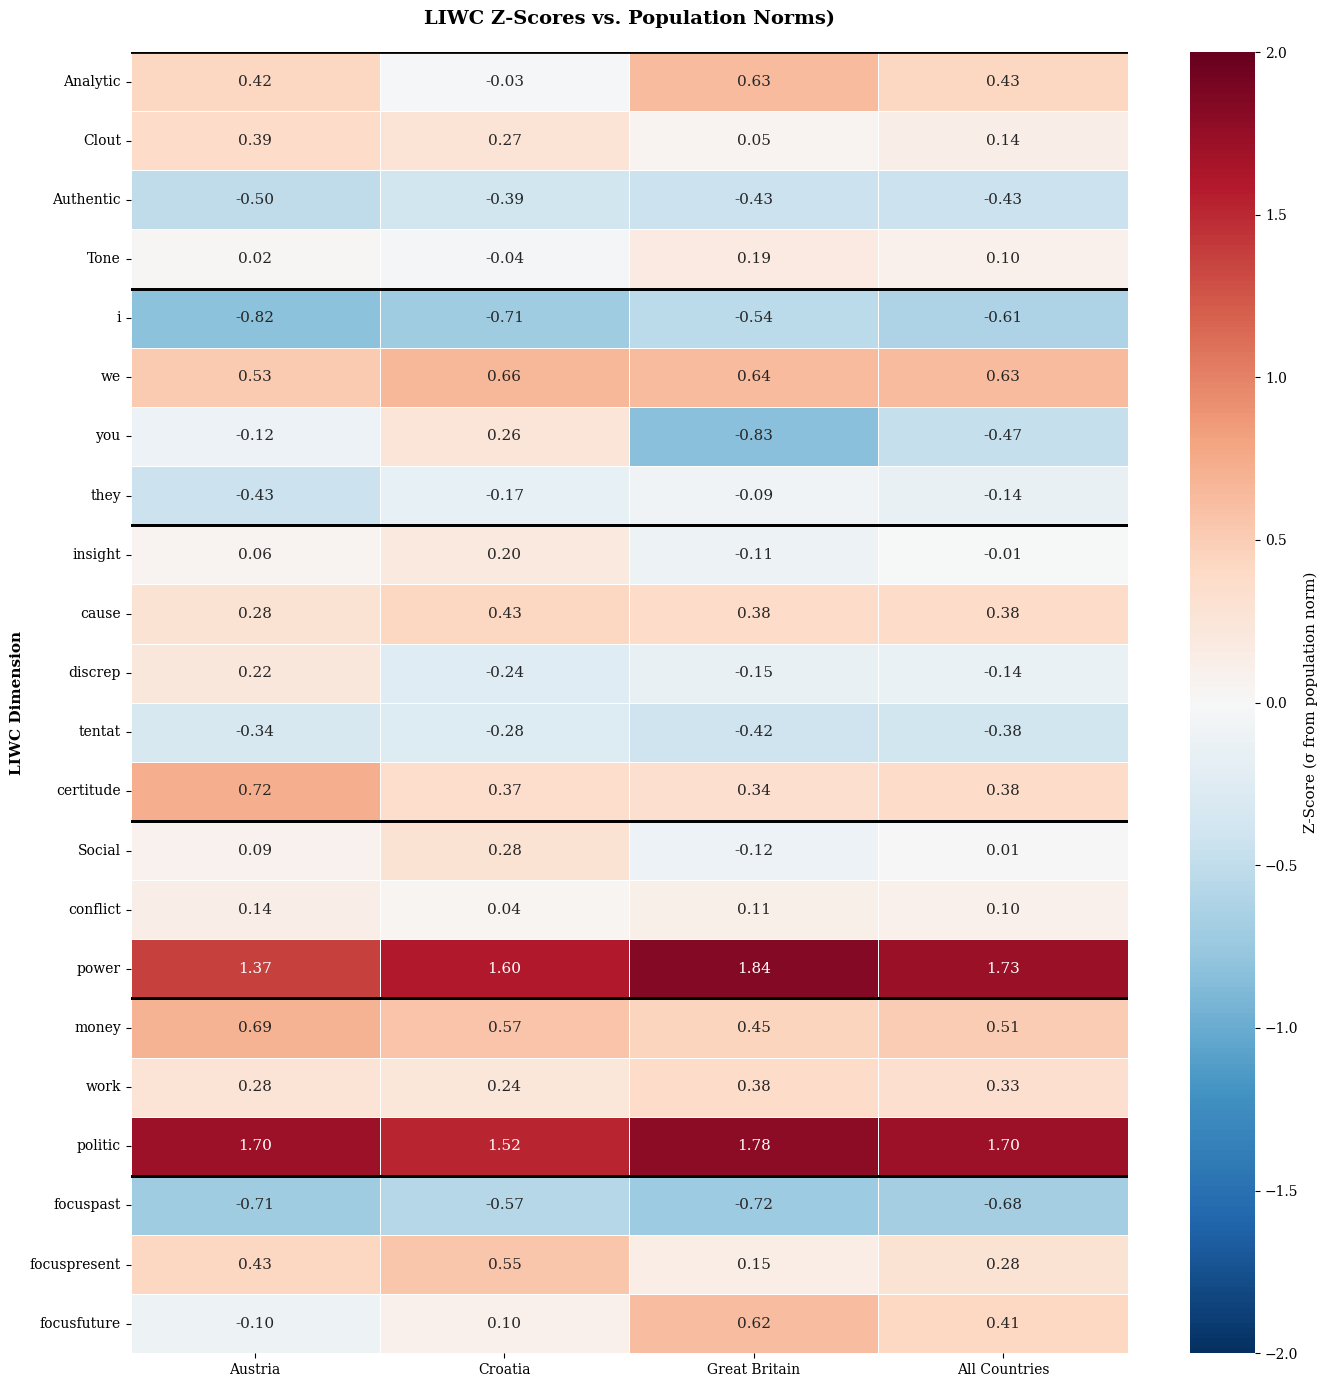

In [2]:
# Cross-country comparison focusing on core political dimensions
def create_political_discourse_heatmap(data, benchmarks):
    """Heatmap showing cross-country differences in key political discourse dimensions."""
    core_dimensions = {
        'Summary Variables': ['Analytic', 'Clout', 'Authentic', 'Tone'],
        'Personal Pronouns': ['i', 'we', 'you', 'they'],
        'Cognitive Processes': ['insight', 'cause', 'discrep', 'tentat', 'certitude'],
        'Social & Conflict': ['Social', 'conflict', 'power'],
        'Policy Domains': ['money', 'work', 'politic'],
        'Time': ['focuspast', 'focuspresent', 'focusfuture']
    }
    
    all_dims = [d for dims in core_dimensions.values() for d in dims]
    
    # Calculate z-scores for each country
    country_means = data.groupby('Country')[all_dims].mean()
    
    # Calculate z-scores for all countries combined
    overall_means = data[all_dims].mean()
    
    # Combine individual countries with "All Countries"
    country_means.loc['All Countries'] = overall_means
    
    benchmark_lookup = benchmarks.set_index('Dimension')
    benchmark_means = benchmark_lookup.loc[all_dims, 'Mean']
    benchmark_stds = benchmark_lookup.loc[all_dims, 'Std']
    z_scores = (country_means - benchmark_means) / benchmark_stds
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 14))
    
    # Add section separators
    section_boundaries = []
    current_pos = 0
    for section, dims in core_dimensions.items():
        section_boundaries.append((current_pos, len(dims), section))
        current_pos += len(dims)
    
    sns.heatmap(z_scores.T, annot=True, fmt=".2f", cmap="RdBu_r", center=0, 
                cbar_kws={'label': 'Z-Score (σ from population norm)'},
                vmin=-2, vmax=2, linewidths=0.5, ax=ax)
    
    for pos, length, label in section_boundaries:
        ax.axhline(y=pos, color='black', linewidth=2)
        if pos + length < len(all_dims):
            ax.axhline(y=pos + length, color='black', linewidth=2)
    
    ax.set_title("LIWC Z-Scores vs. Population Norms)", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel("LIWC Dimension", fontweight='bold')
    ax.set_xlabel("", fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'z_scores_countires.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    return z_scores

z_scores_country = create_political_discourse_heatmap(LIWC_ALL, LIWC_benchmarks)

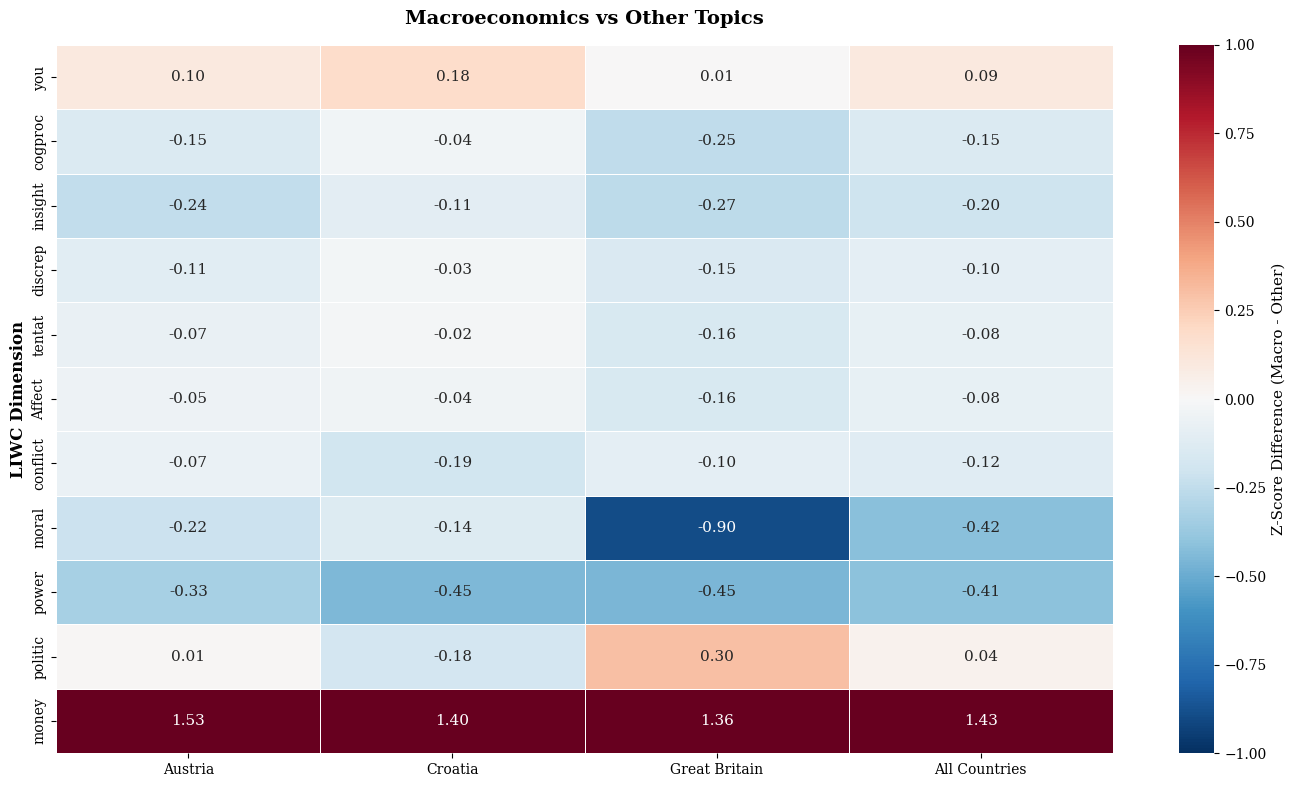

In [10]:
# Macroeconomics Analysis - Simplified (Z-scores only)
LIWC_ALL['Topic_Group'] = LIWC_ALL['Our_Topic'].apply(
    lambda x: 'Macroeconomics' if x == 'Macroeconomics' else 'Other Topics'
)

macro_dims = KEY_LIWC_DIMENSIONS

# Z-score normalization
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
macro_z_data = LIWC_ALL.copy()

for dim in macro_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    macro_z_data[f'{dim}_z'] = (LIWC_ALL[dim] - benchmark_mean) / benchmark_std

# Calculate z-scores by country and topic group
heatmap_data = macro_z_data.groupby(['Country', 'Topic_Group'])[[f'{d}_z' for d in macro_dims]].mean()
heatmap_data.columns = [col.replace('_z', '') for col in heatmap_data.columns]

# Calculate differences (Macro - Other) for each country
countries = sorted(macro_z_data['Country'].unique())
difference_data = []
row_labels = []

for country in countries:
    macro_vals = heatmap_data.loc[(country, 'Macroeconomics'), :].values
    other_vals = heatmap_data.loc[(country, 'Other Topics'), :].values
    difference = macro_vals - other_vals
    difference_data.append(difference)
    row_labels.append(country)

# Add "All Countries"
country_diffs_array = np.array(difference_data)
all_countries_diff = country_diffs_array.mean(axis=0)
difference_data.append(all_countries_diff)
row_labels.append('All Countries')

heatmap_display_df = pd.DataFrame(difference_data, index=row_labels, columns=heatmap_data.columns)

# Filter dimensions: keep only those where at least one country has |z-score| >= 0.15
dimensions_to_keep = []
for dim in heatmap_display_df.columns:
    max_abs_diff = heatmap_display_df[dim].abs().max()
    if max_abs_diff >= 0.15:
        dimensions_to_keep.append(dim)

heatmap_display_df_filtered = heatmap_display_df[dimensions_to_keep]

# Create simplified figure with single heatmap
fig, ax = plt.subplots(figsize=(14, max(8, len(dimensions_to_keep) * 0.4)))

sns.heatmap(heatmap_display_df_filtered.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           ax=ax, cbar_kws={'label': 'Z-Score Difference (Macro - Other)'}, 
           vmin=-1.0, vmax=1.0, linewidths=0.5)

ax.set_title('Macroeconomics vs Other Topics', 
             fontweight='bold', fontsize=14, pad=15)
ax.set_xlabel('', fontweight='bold', fontsize=12)
ax.set_ylabel('LIWC Dimension', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_macroeconomics_simple.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

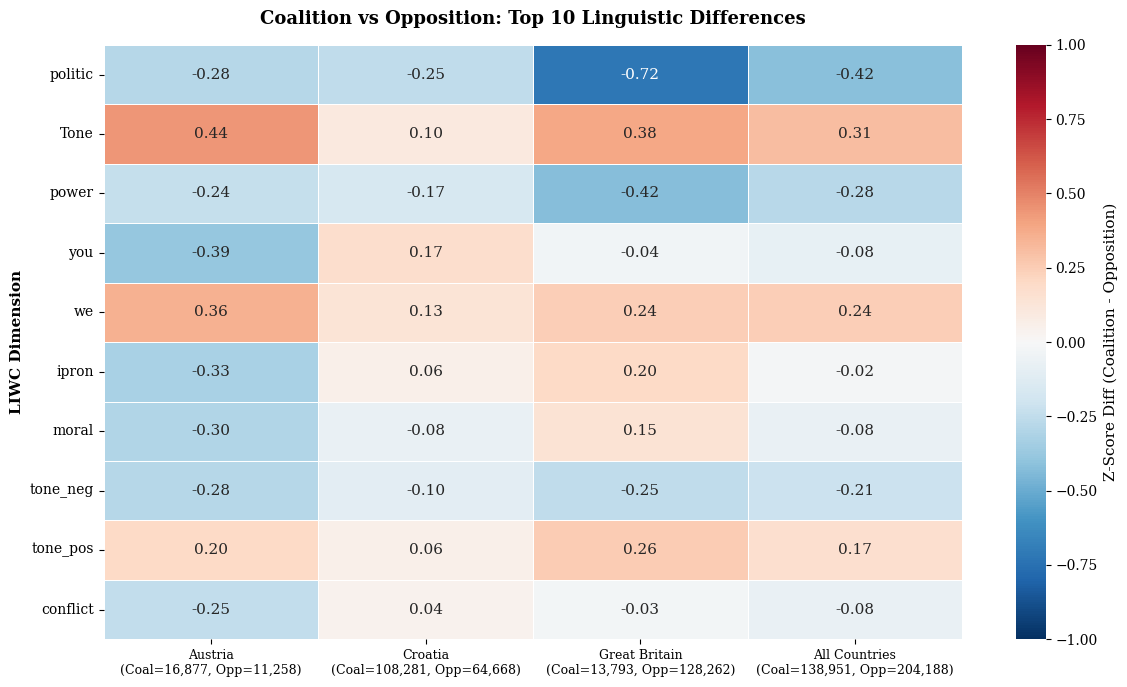

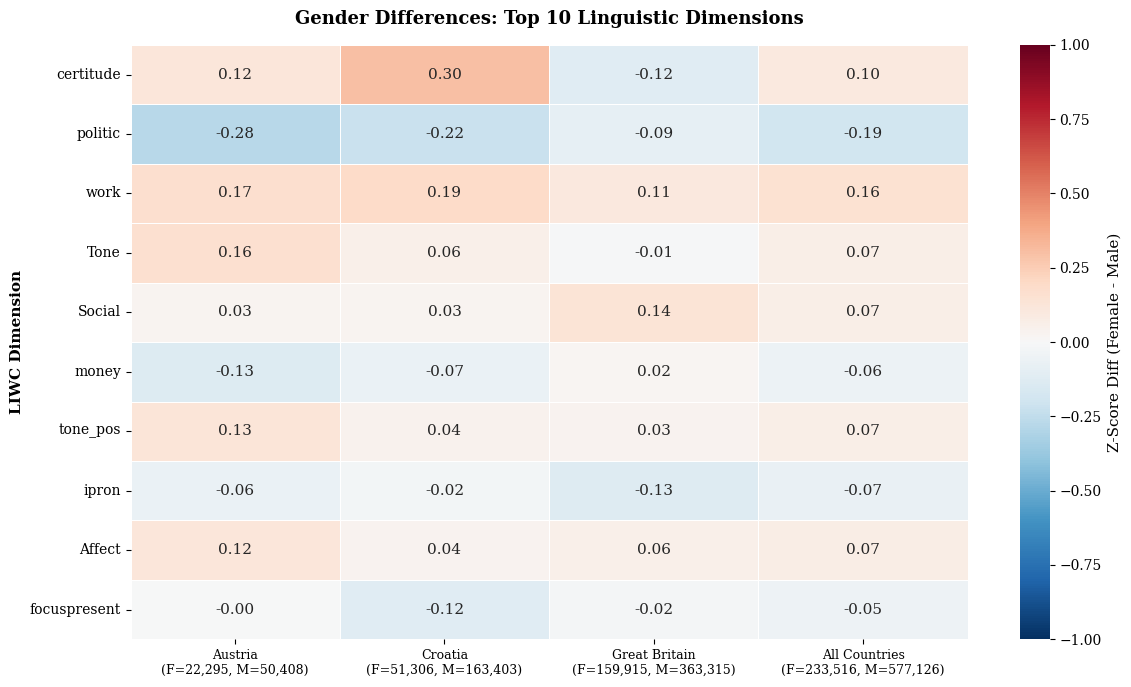

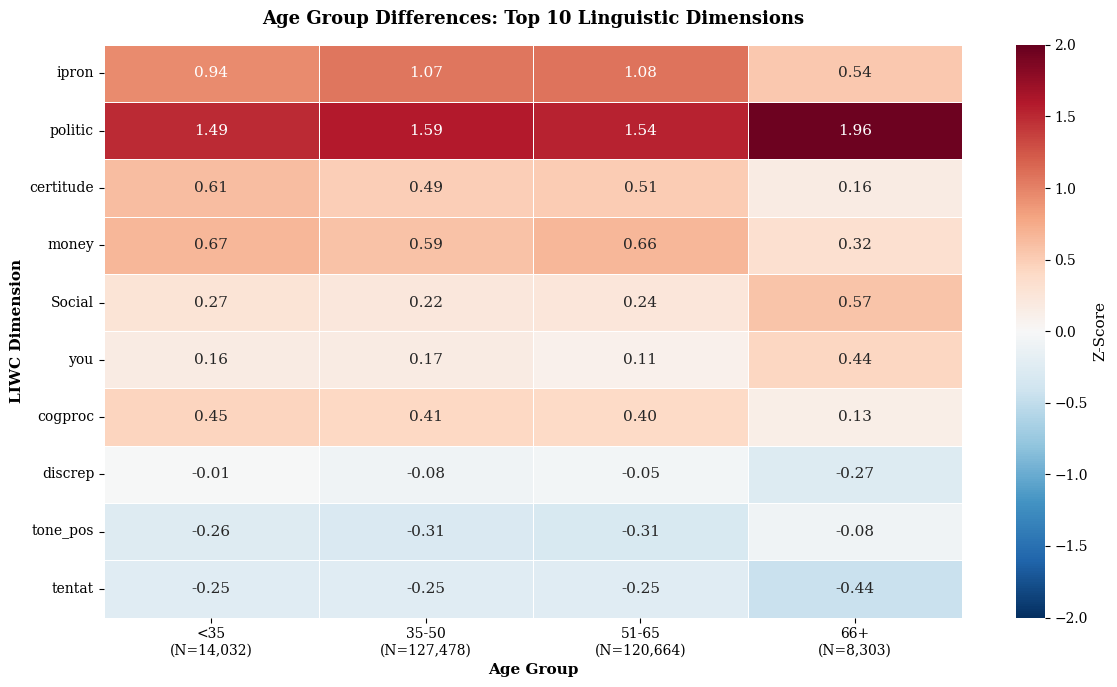

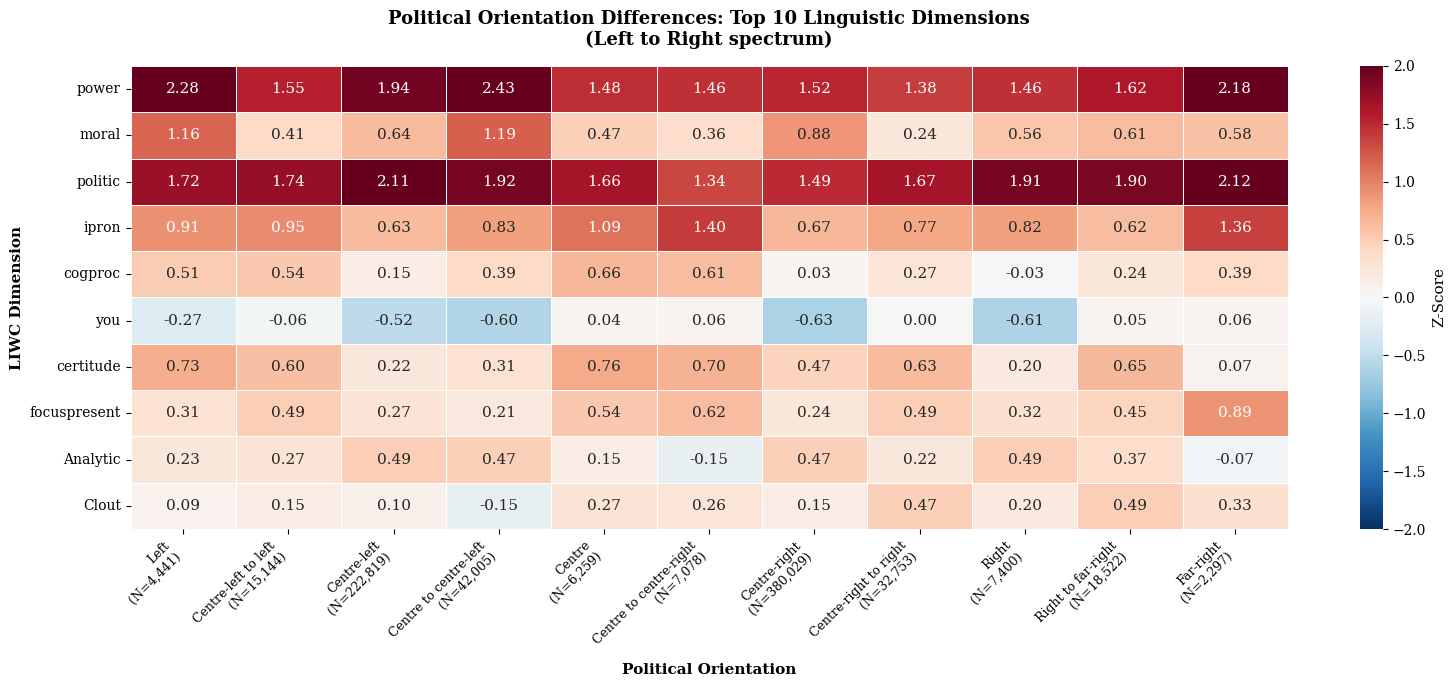

In [13]:
# Political Covariates Analysis - Top 10 Dimensions with N sizes
covariate_dims = KEY_LIWC_DIMENSIONS

# Z-score normalize
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')
covariate_data = LIWC_ALL.copy()

for dim in covariate_dims:
    benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
    benchmark_std = benchmark_lookup.loc[dim, 'Std']
    covariate_data[f'{dim}_z'] = (LIWC_ALL[dim] - benchmark_mean) / benchmark_std

# ============================================================================
# FIGURE 1: Party Status (Coalition vs Opposition)
# ============================================================================

coalition_data = covariate_data[covariate_data['Party_status'].isin(['Coalition', 'Opposition'])]
status_by_country = coalition_data.groupby(['Country', 'Party_status'])[[f'{d}_z' for d in covariate_dims]].mean()
status_by_country.columns = [c.replace('_z', '') for c in status_by_country.columns]

# Get N sizes
status_n_sizes = coalition_data.groupby(['Country', 'Party_status']).size()

# Calculate differences for each country
countries = sorted(coalition_data['Country'].unique())
status_diff_data = []
for country in countries:
    coal_vals = status_by_country.loc[(country, 'Coalition'), :].values
    opp_vals = status_by_country.loc[(country, 'Opposition'), :].values
    difference = coal_vals - opp_vals
    status_diff_data.append(difference)

# Add "All Countries"
country_diffs_array = np.array(status_diff_data)
all_countries_diff = country_diffs_array.mean(axis=0)
status_diff_data.append(all_countries_diff)

status_diff_df = pd.DataFrame(status_diff_data, 
                              index=countries + ['All Countries'], 
                              columns=status_by_country.columns)

# Select top 10
max_abs_diffs = status_diff_df.abs().max(axis=0)
top_10_status = max_abs_diffs.nlargest(10).index.tolist()
status_diff_df_top10 = status_diff_df[top_10_status]

fig1, ax1 = plt.subplots(figsize=(12, 7))
sns.heatmap(status_diff_df_top10.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           ax=ax1, cbar_kws={'label': 'Z-Score Diff (Coalition - Opposition)'}, 
           vmin=-1, vmax=1, linewidths=0.5)

# Add N sizes to x-labels
new_labels = []
for country in countries:
    n_coal = status_n_sizes.get((country, 'Coalition'), 0)
    n_opp = status_n_sizes.get((country, 'Opposition'), 0)
    new_labels.append(f'{country}\n(Coal={n_coal:,}, Opp={n_opp:,})')
# Total for All Countries
total_coal = sum(status_n_sizes.get((c, 'Coalition'), 0) for c in countries)
total_opp = sum(status_n_sizes.get((c, 'Opposition'), 0) for c in countries)
new_labels.append(f'All Countries\n(Coal={total_coal:,}, Opp={total_opp:,})')
ax1.set_xticklabels(new_labels, fontsize=9)

ax1.set_title('Coalition vs Opposition: Top 10 Linguistic Differences', 
             fontweight='bold', fontsize=13, pad=15)
ax1.set_xlabel('', fontweight='bold')
ax1.set_ylabel('LIWC Dimension', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_covariate_party_status.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 2: Gender (Female vs Male)
# ============================================================================

gender_data = covariate_data[covariate_data['Speaker_gender'].isin(['M', 'F'])]
gender_by_country = gender_data.groupby(['Country', 'Speaker_gender'])[[f'{d}_z' for d in covariate_dims]].mean()
gender_by_country.columns = [c.replace('_z', '') for c in gender_by_country.columns]

# Get N sizes
gender_n_sizes = gender_data.groupby(['Country', 'Speaker_gender']).size()

# Calculate differences
gender_diff_data = []
for country in countries:
    female_vals = gender_by_country.loc[(country, 'F'), :].values
    male_vals = gender_by_country.loc[(country, 'M'), :].values
    difference = female_vals - male_vals
    gender_diff_data.append(difference)

# Add "All Countries"
country_diffs_array = np.array(gender_diff_data)
all_countries_diff = country_diffs_array.mean(axis=0)
gender_diff_data.append(all_countries_diff)

gender_diff_df = pd.DataFrame(gender_diff_data, 
                              index=countries + ['All Countries'], 
                              columns=gender_by_country.columns)

# Select top 10
max_abs_diffs = gender_diff_df.abs().max(axis=0)
top_10_gender = max_abs_diffs.nlargest(10).index.tolist()
gender_diff_df_top10 = gender_diff_df[top_10_gender]

fig2, ax2 = plt.subplots(figsize=(12, 7))
sns.heatmap(gender_diff_df_top10.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           ax=ax2, cbar_kws={'label': 'Z-Score Diff (Female - Male)'}, 
           vmin=-1, vmax=1, linewidths=0.5)

# Add N sizes to x-labels
new_labels = []
for country in countries:
    n_f = gender_n_sizes.get((country, 'F'), 0)
    n_m = gender_n_sizes.get((country, 'M'), 0)
    new_labels.append(f'{country}\n(F={n_f:,}, M={n_m:,})')
# Total
total_f = sum(gender_n_sizes.get((c, 'F'), 0) for c in countries)
total_m = sum(gender_n_sizes.get((c, 'M'), 0) for c in countries)
new_labels.append(f'All Countries\n(F={total_f:,}, M={total_m:,})')
ax2.set_xticklabels(new_labels, fontsize=9)

ax2.set_title('Gender Differences: Top 10 Linguistic Dimensions', 
             fontweight='bold', fontsize=13, pad=15)
ax2.set_xlabel('', fontweight='bold')
ax2.set_ylabel('LIWC Dimension', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_covariate_gender.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 3: Age Groups
# ============================================================================

age_data = covariate_data[(covariate_data['Speaker_age'] >= 18) & 
                         (covariate_data['Speaker_age'] <= 100)]

age_data['Age_Group'] = pd.cut(age_data['Speaker_age'], 
                               bins=[20, 35, 50, 65, 80],
                               labels=['<35', '35-50', '51-65', '66+'])

age_means = age_data.groupby('Age_Group')[[f'{d}_z' for d in covariate_dims]].mean()
age_means.columns = [c.replace('_z', '') for c in age_means.columns]

# Get N sizes
age_n_sizes = age_data.groupby('Age_Group').size()

# Select top 10
age_ranges = age_means.max() - age_means.min()
top_10_age = age_ranges.nlargest(10).index.tolist()
age_means_top10 = age_means[top_10_age]

fig3, ax3 = plt.subplots(figsize=(12, 7))
sns.heatmap(age_means_top10.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           ax=ax3, cbar_kws={'label': 'Z-Score'}, vmin=-2, vmax=2, linewidths=0.5)

# Add N sizes to x-labels
new_labels = [f'{age}\n(N={age_n_sizes[age]:,})' for age in age_means.index]
ax3.set_xticklabels(new_labels, fontsize=10)

ax3.set_title('Age Group Differences: Top 10 Linguistic Dimensions', 
             fontweight='bold', fontsize=13, pad=15)
ax3.set_xlabel('Age Group', fontweight='bold')
ax3.set_ylabel('LIWC Dimension', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_covariate_age.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# FIGURE 4: Political Orientation (Left-Right)
# ============================================================================

# Exclude low-count and missing orientation values
excluded_orientations = [
    '-',  # Missing
    'Centre-right;Centre-left',  # N=20
    'Centre-right;;Centre to centre-left',  # N=6
    'Centre-right;Centre to centre-left'  # N=3
]

orientation_data = covariate_data[
    (~covariate_data['Party_orientation'].isin(excluded_orientations)) &
    (covariate_data['Party_orientation'].notna())
].copy()

# Calculate means by raw orientation
orientation_means = orientation_data.groupby('Party_orientation')[[f'{d}_z' for d in covariate_dims]].mean()
orientation_means.columns = [c.replace('_z', '') for c in orientation_means.columns]

# Get N sizes
orientation_n_sizes = orientation_data.groupby('Party_orientation').size()

# Order from left to right (manual ordering based on political spectrum)
orientation_order = [
    'Far-left',
    'Left',
    'Centre-left to left',
    'Centre-left',
    'Centre to centre-left',
    'Centre',
    'Centre to centre-right',
    'Centre-right',
    'Centre-right to right',
    'Right',
    'Right to far-right',
    'Far-right'
]
# Keep only orientations that exist in the data
orientation_order = [o for o in orientation_order if o in orientation_means.index]
orientation_means = orientation_means.loc[orientation_order]

# Select top 10 dimensions
orientation_ranges = orientation_means.max() - orientation_means.min()
top_10_orientation = orientation_ranges.nlargest(10).index.tolist()
orientation_means_top10 = orientation_means[top_10_orientation]

fig4, ax4 = plt.subplots(figsize=(16, 7))
sns.heatmap(orientation_means_top10.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
           ax=ax4, cbar_kws={'label': 'Z-Score'}, vmin=-2, vmax=2, linewidths=0.5)

# Add N sizes to x-labels
new_labels = [f'{orient}\n(N={orientation_n_sizes[orient]:,})' for orient in orientation_means_top10.index]
ax4.set_xticklabels(new_labels, fontsize=9, rotation=45, ha='right')

ax4.set_title('Political Orientation Differences: Top 10 Linguistic Dimensions\n(Left to Right spectrum)', 
             fontweight='bold', fontsize=13, pad=15)
ax4.set_xlabel('Political Orientation', fontweight='bold')
ax4.set_ylabel('LIWC Dimension', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'fig_covariate_orientation.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

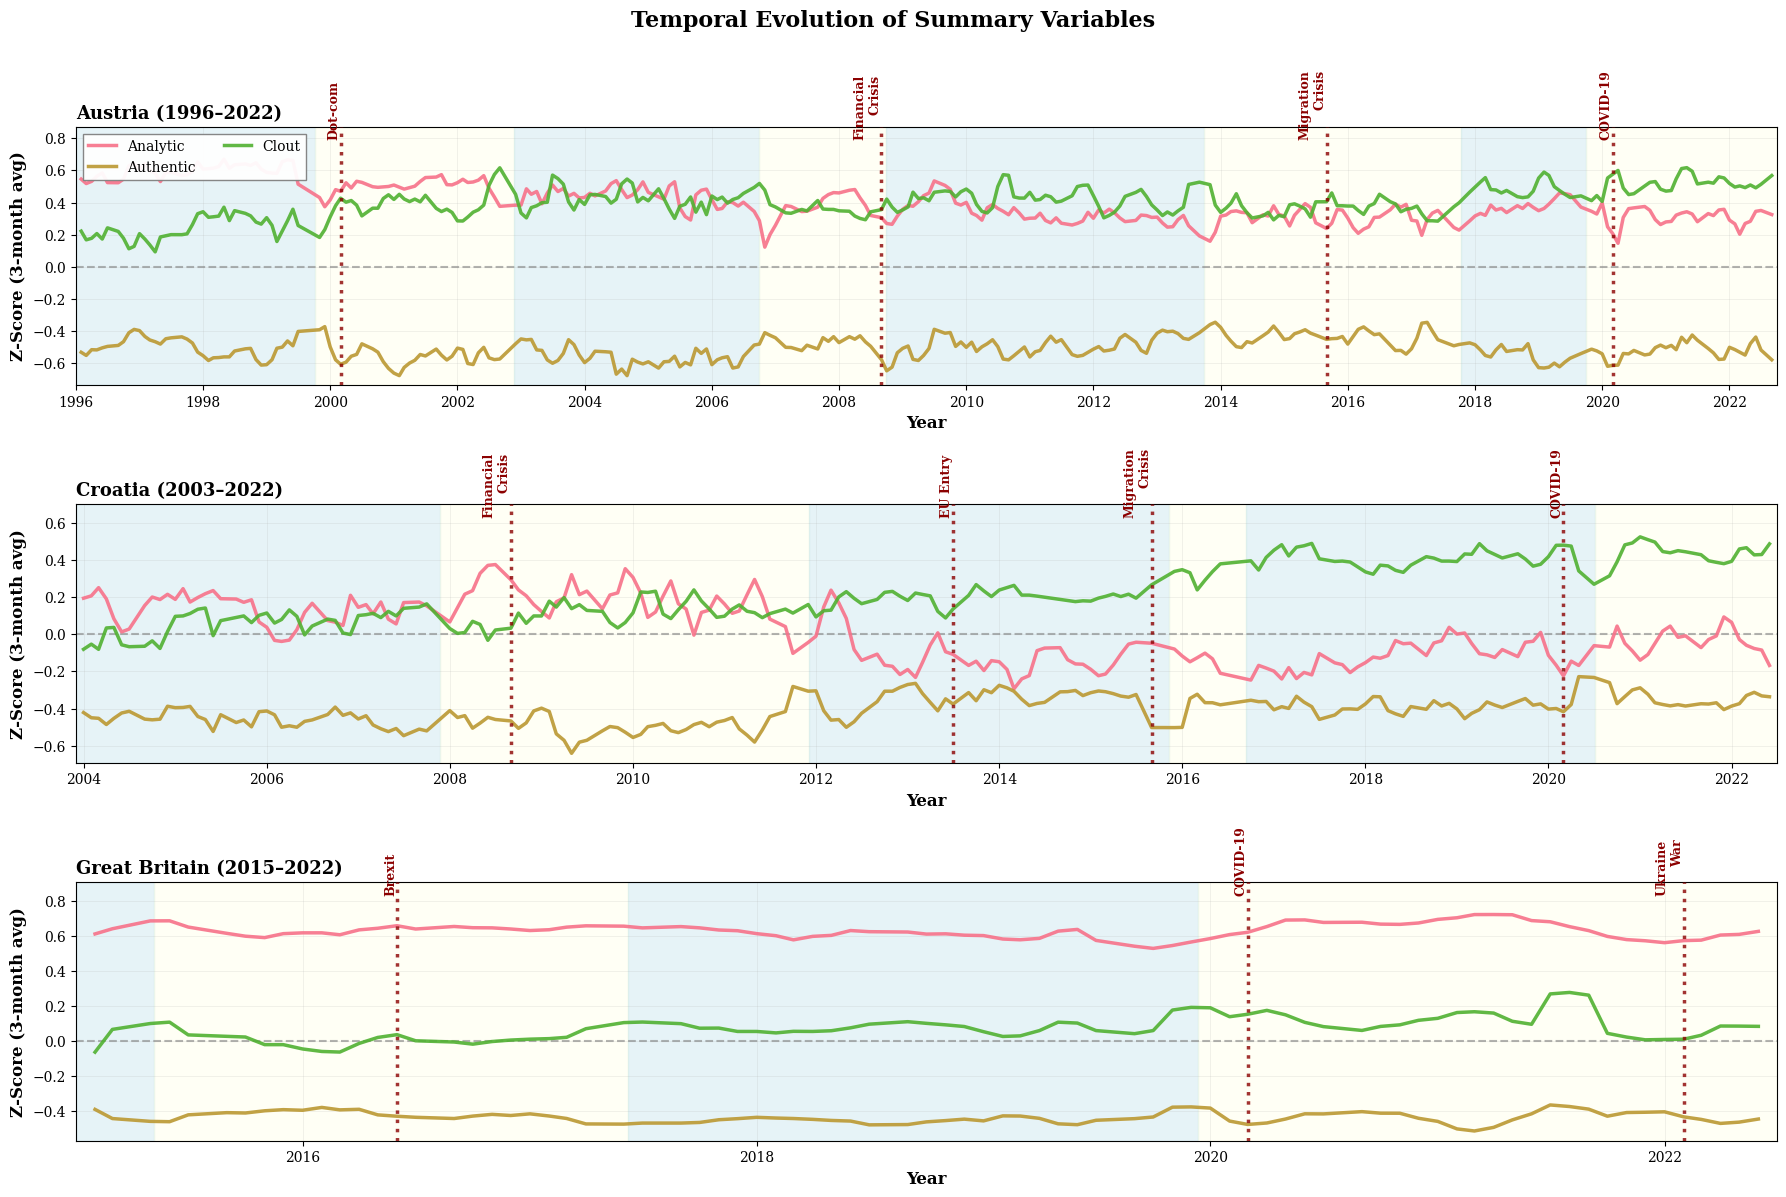

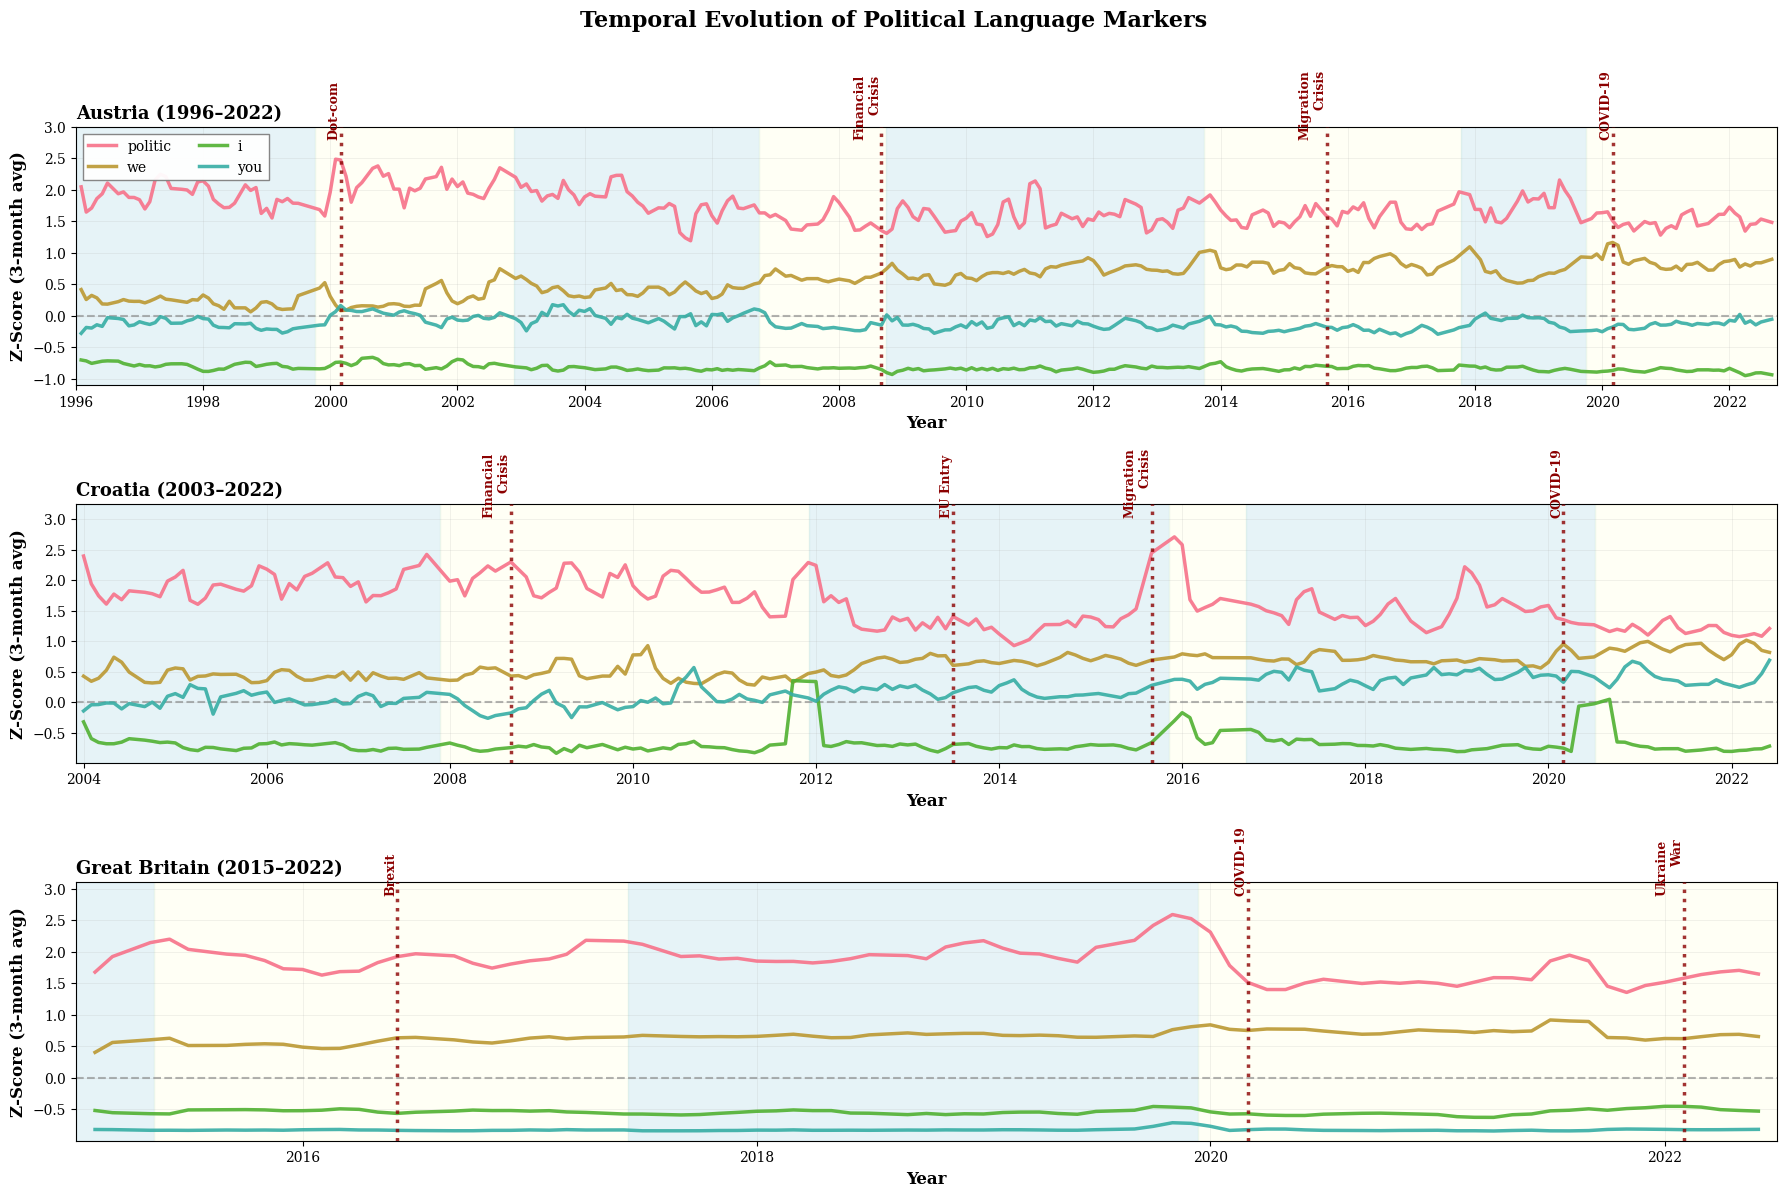

In [7]:
# Temporal Analysis - Split into TWO figures
# FIGURE A: Summary Variables
# FIGURE B: Political Language

# Z-score normalize
benchmark_lookup = LIWC_benchmarks.set_index('Dimension')

# Define country-specific events
country_events = {
    'Austria': {
        '2000-03': 'Dot-com',
        '2008-09': 'Financial\nCrisis',
        '2015-09': 'Migration\nCrisis',
        '2020-03': 'COVID-19'
    },
    'Croatia': {
        '2008-09': 'Financial\nCrisis',
        '2013-07': 'EU Entry',
        '2015-09': 'Migration\nCrisis',
        '2020-03': 'COVID-19'
    },
    'Great Britain': {
        '2016-06': 'Brexit',
        '2020-03': 'COVID-19',
        '2022-02': 'Ukraine\nWar'
    }
}

# Define election dates
election_dates = {
    'Austria': [
        '1999-10-03', '2002-11-24', '2006-10-01', '2008-09-28',
        '2013-09-29', '2017-10-15', '2019-09-29'
    ],
    'Croatia': [
        '2003-11-23', '2007-11-25', '2011-12-04', '2015-11-08',
        '2016-09-11', '2020-07-05'
    ],
    'Great Britain': [
        '2001-06-07', '2005-05-05', '2010-05-06', '2015-05-07',
        '2017-06-08', '2019-12-12'
    ]
}

# Define two dimension groups
temporal_groups = {
    'A_Summary': ['Analytic', 'Authentic', 'Clout'],
    'B_Political': ['politic', 'we', 'i', 'you']
}

countries = sorted(LIWC_ALL['Country'].unique())

# Process data for both figures
for fig_key, temporal_dims in temporal_groups.items():
    fig, axes = plt.subplots(3, 1, figsize=(18, 12))
    fig_title = 'Summary Variables' if 'Summary' in fig_key else 'Political Language Markers'
    fig.suptitle(f'Temporal Evolution of {fig_title}', 
                fontsize=16, fontweight='bold', y=0.995)
    
    for idx, country in enumerate(countries):
        ax = axes[idx]
        
        # Filter data for this country
        country_data = LIWC_ALL[LIWC_ALL['Country'] == country].copy()
        temporal_data = country_data[country_data['Date'].notna()].copy()
        
        # Create year-month column
        temporal_data['YearMonth'] = temporal_data['Date'].dt.to_period('M')
        
        # Filter months with sufficient data
        month_counts = temporal_data['YearMonth'].value_counts()
        sufficient_months = month_counts[month_counts >= 5].index
        temporal_data = temporal_data[temporal_data['YearMonth'].isin(sufficient_months)]
        
        if len(temporal_data) == 0:
            continue
        
        # Z-score normalize
        temporal_z_data = temporal_data.copy()
        for dim in temporal_dims:
            benchmark_mean = benchmark_lookup.loc[dim, 'Mean']
            benchmark_std = benchmark_lookup.loc[dim, 'Std']
            temporal_z_data[f'{dim}_z'] = (temporal_data[dim] - benchmark_mean) / benchmark_std
        
        # Calculate monthly means
        monthly_data = temporal_z_data.groupby('YearMonth')[[f'{d}_z' for d in temporal_dims]].mean()
        monthly_data.columns = [c.replace('_z', '') for c in monthly_data.columns]
        monthly_data.index = monthly_data.index.to_timestamp()
        
        # Apply 3-month rolling average
        monthly_data_smooth = monthly_data.rolling(window=3, center=True).mean()
        
        # Calculate y-axis limits
        y_min = monthly_data_smooth.min().min()
        y_max = monthly_data_smooth.max().max()
        y_range = y_max - y_min
        y_padding = y_range * 0.15
        
        # Add electoral period shading
        elections = [pd.to_datetime(d) for d in election_dates.get(country, [])]
        data_start = monthly_data_smooth.index.min()
        data_end = monthly_data_smooth.index.max()
        elections_in_range = [e for e in elections if e >= data_start and e <= data_end]
        
        if not elections_in_range or elections_in_range[0] > data_start:
            elections_in_range.insert(0, data_start)
        if elections_in_range[-1] < data_end:
            elections_in_range.append(data_end)
        
        # Shade periods
        for i in range(len(elections_in_range) - 1):
            start_date = elections_in_range[i]
            end_date = elections_in_range[i + 1]
            color = 'lightblue' if i % 2 == 0 else 'lightyellow'
            ax.axvspan(start_date, end_date, alpha=0.3, color=color, zorder=0)
        
        # Plot lines
        for dim in monthly_data_smooth.columns:
            ax.plot(monthly_data_smooth.index, monthly_data_smooth[dim], 
                    linewidth=2.5, label=dim, alpha=0.9, zorder=3)
        
        # Add population norm line
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.6, linewidth=1.5, zorder=2)
        
        # Add event markers
        events = country_events.get(country, {})
        for event_month, event in events.items():
            event_date = pd.to_datetime(event_month)
            if event_date >= monthly_data_smooth.index.min() and event_date <= monthly_data_smooth.index.max():
                ax.axvline(x=event_date, color='darkred', linestyle=':', alpha=0.8, 
                          linewidth=2.5, zorder=4)
                ax.text(event_date, y_max + y_padding * 0.6, event, 
                       rotation=90, va='bottom', ha='right', fontsize=9, 
                       color='darkred', fontweight='bold', zorder=5)
        
        # Formatting
        ax.set_xlabel('Year', fontweight='bold', fontsize=12)
        ax.set_ylabel('Z-Score (3-month avg)', fontweight='bold', fontsize=12)
        
        date_range = f"{monthly_data_smooth.index.min().strftime('%Y')}–{monthly_data_smooth.index.max().strftime('%Y')}"
        ax.set_title(f'{country} ({date_range})', 
                    fontweight='bold', loc='left', fontsize=13)
        ax.grid(True, alpha=0.25, linewidth=0.5, zorder=1)
        
        # Format x-axis
        import matplotlib.dates as mdates
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        ax.set_xlim(monthly_data_smooth.index.min(), monthly_data_smooth.index.max())
        ax.set_ylim(y_min - y_padding * 0.3, y_max + y_padding)
        
        # Add legend only to first subplot
        if idx == 0:
            ax.legend(loc='upper left', ncol=2, fontsize=10, framealpha=0.95, 
                     edgecolor='gray', fancybox=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    fig_suffix = 'summary' if 'Summary' in fig_key else 'political'
    plt.savefig(os.path.join(output_dir, f'fig_temporal_liwc_{fig_suffix}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()

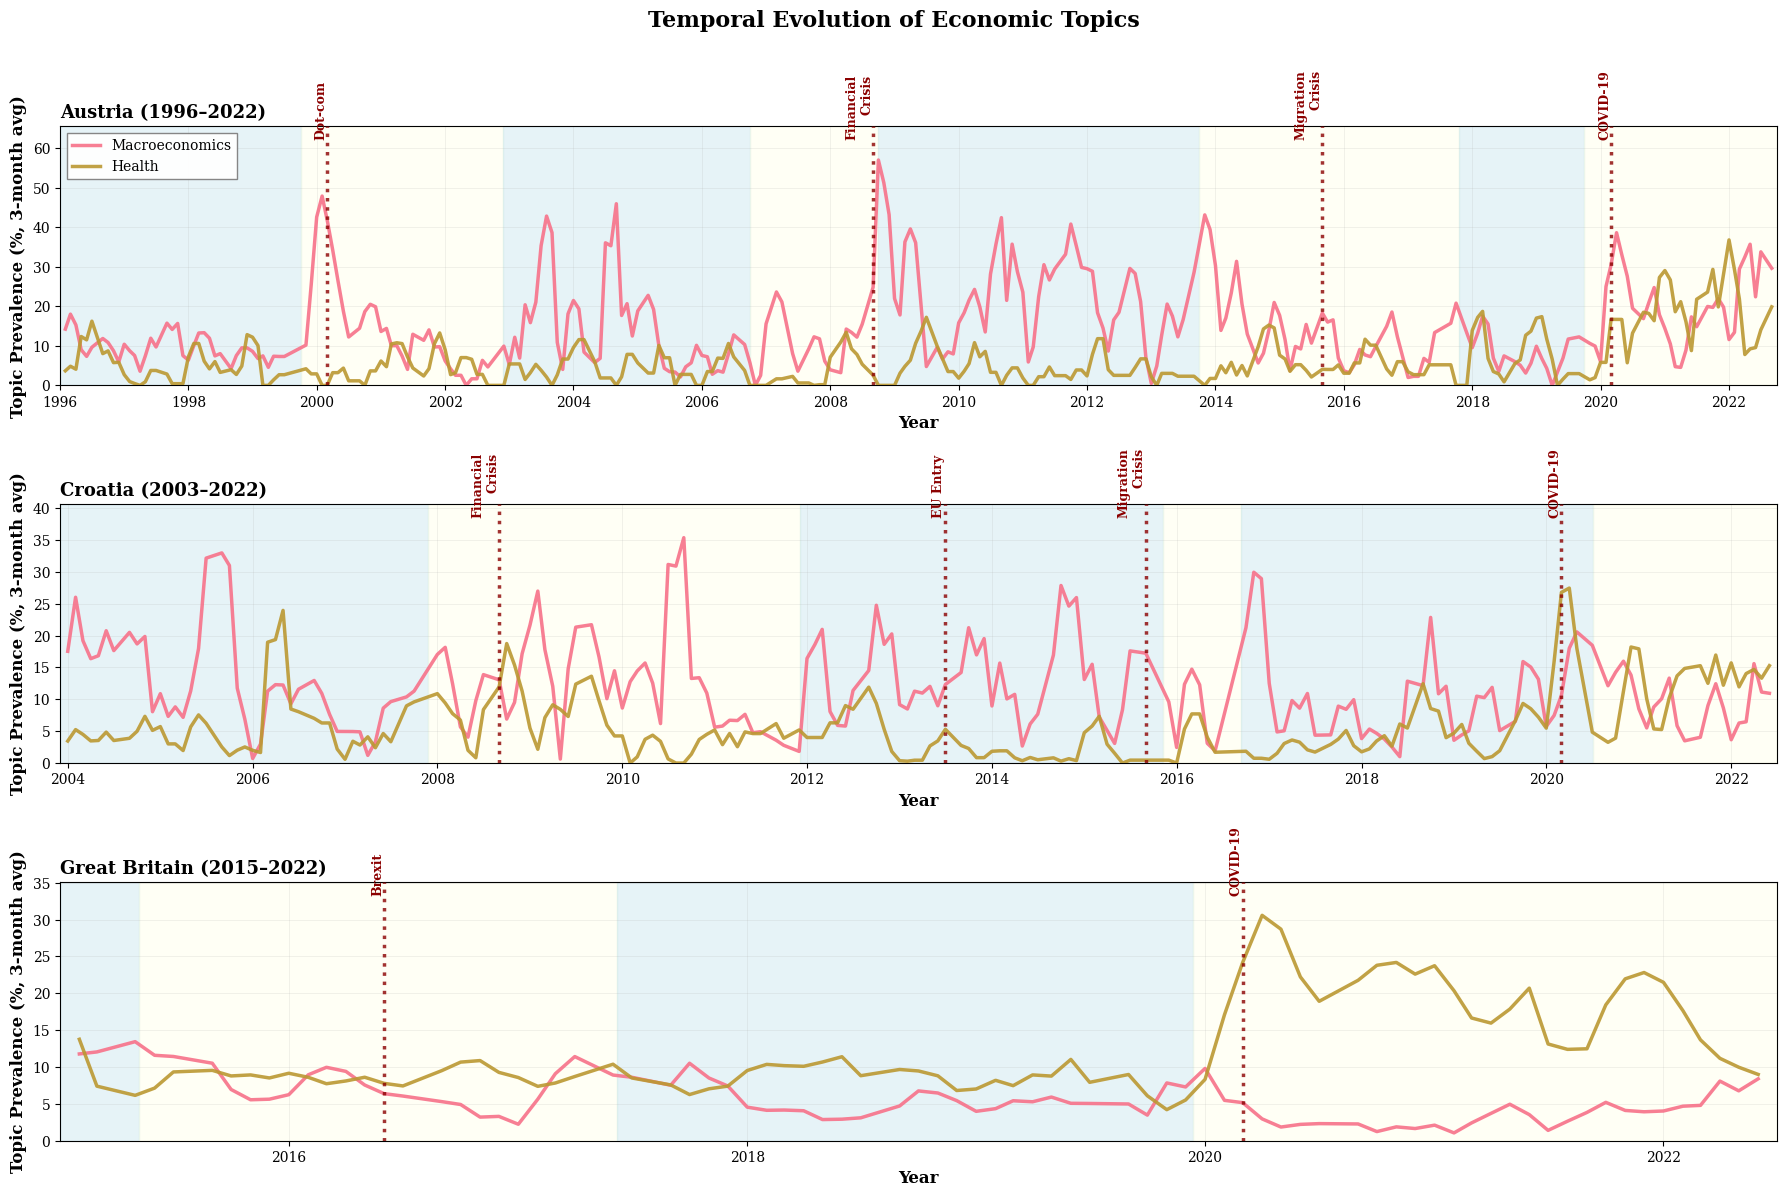

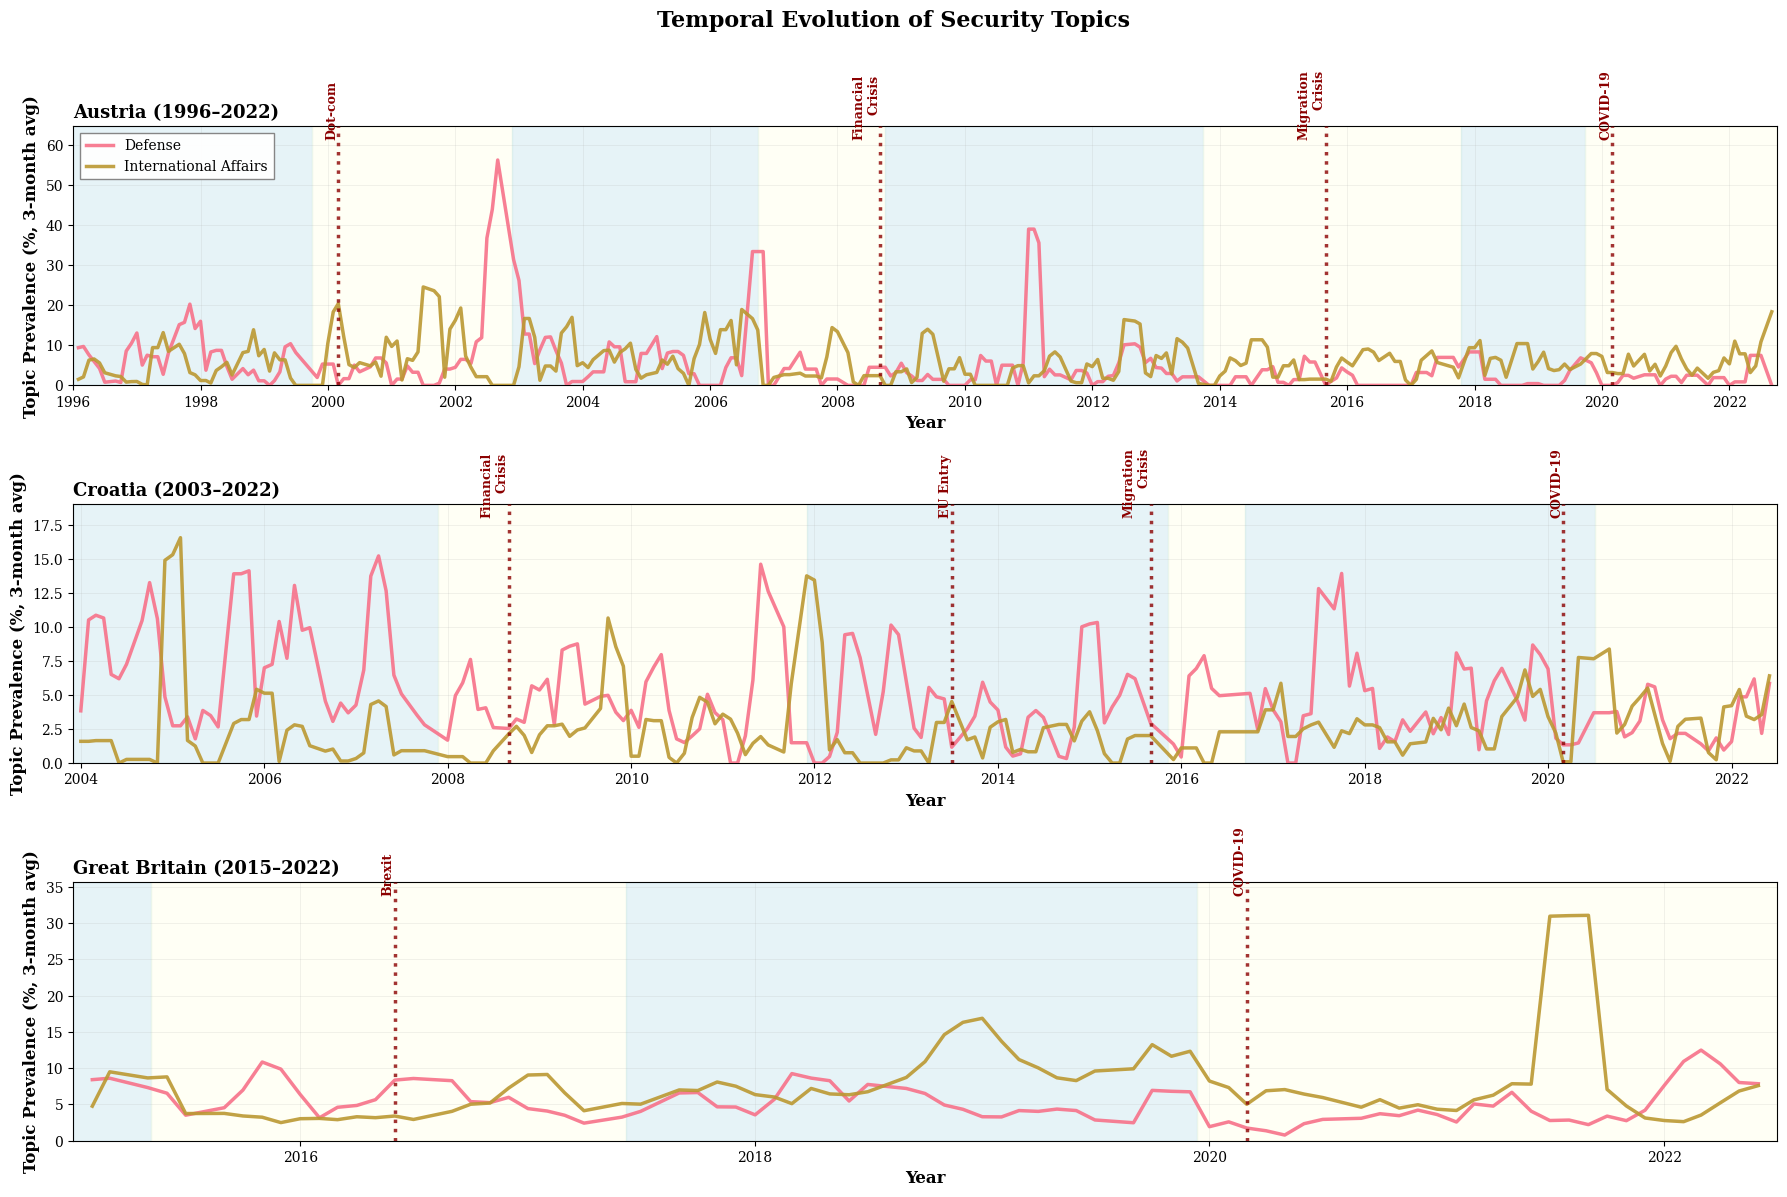

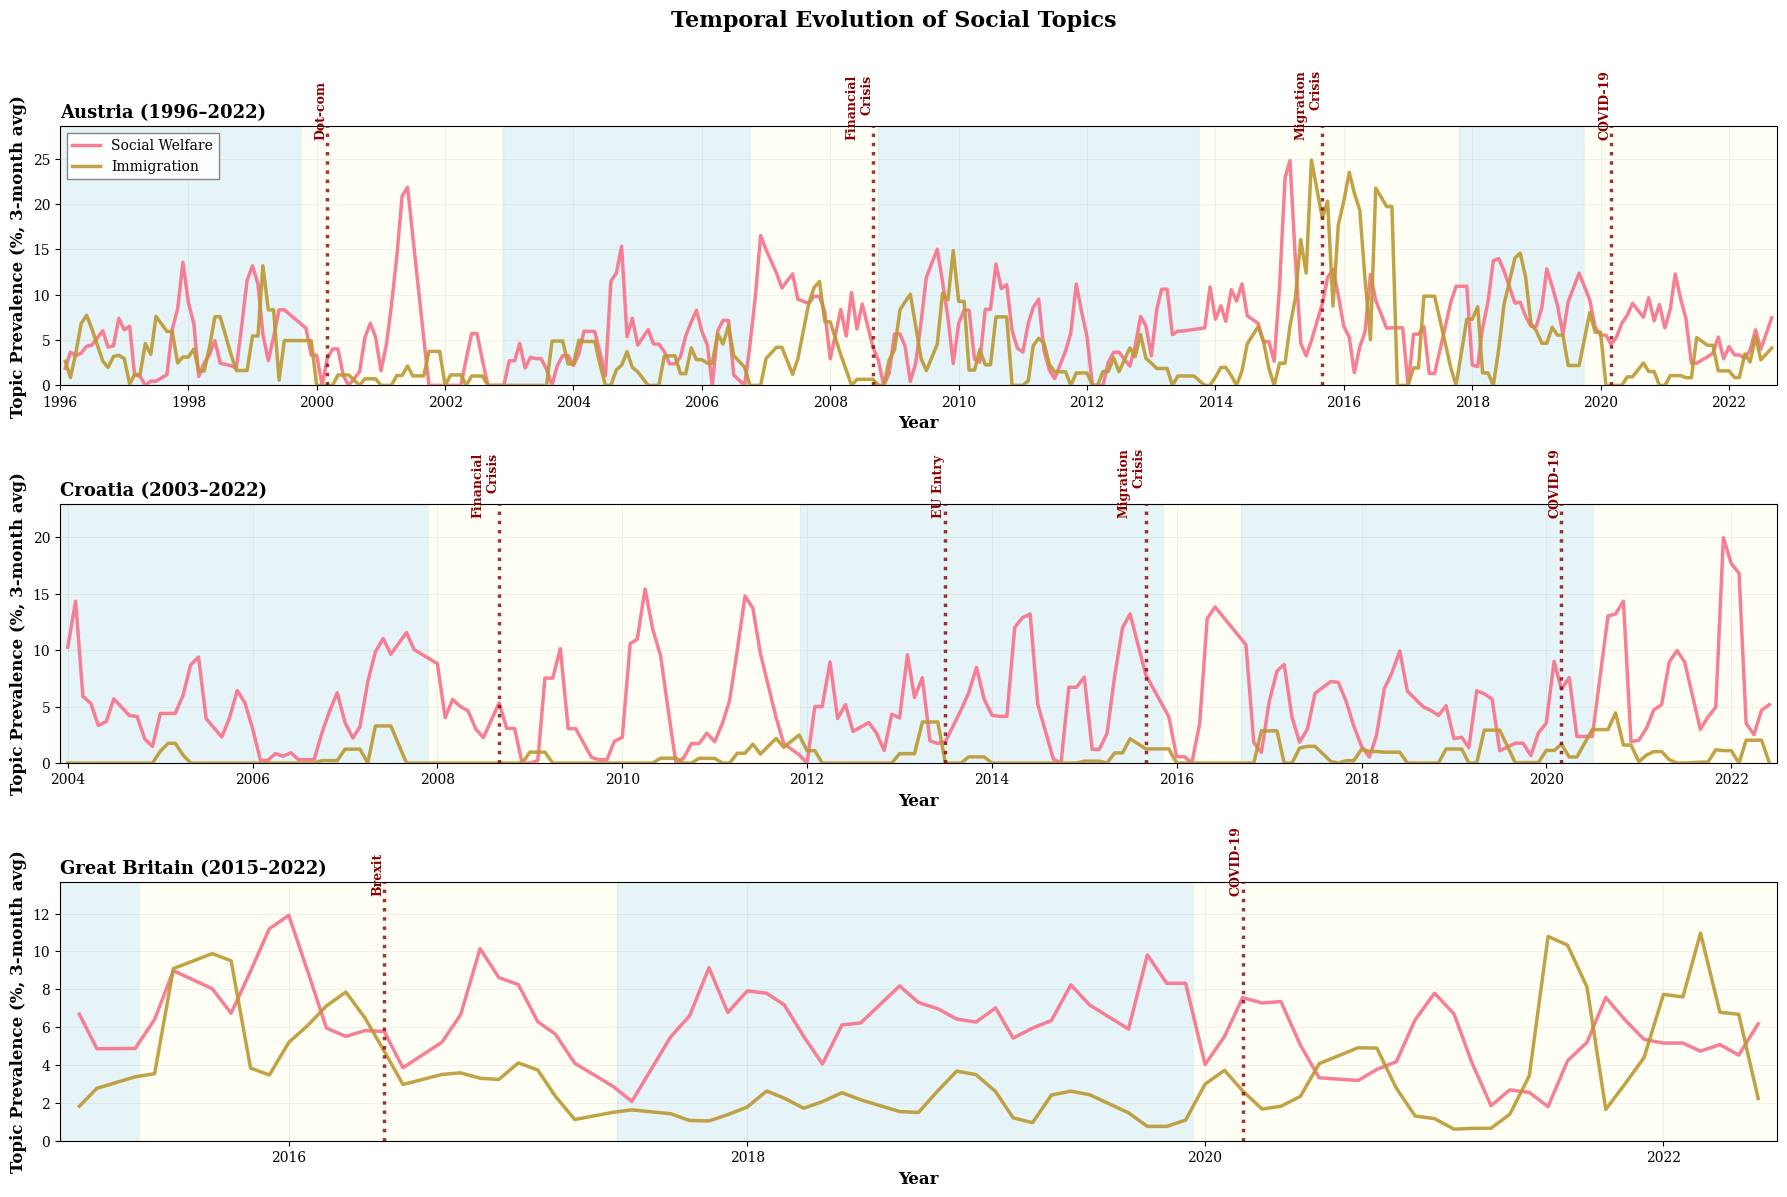

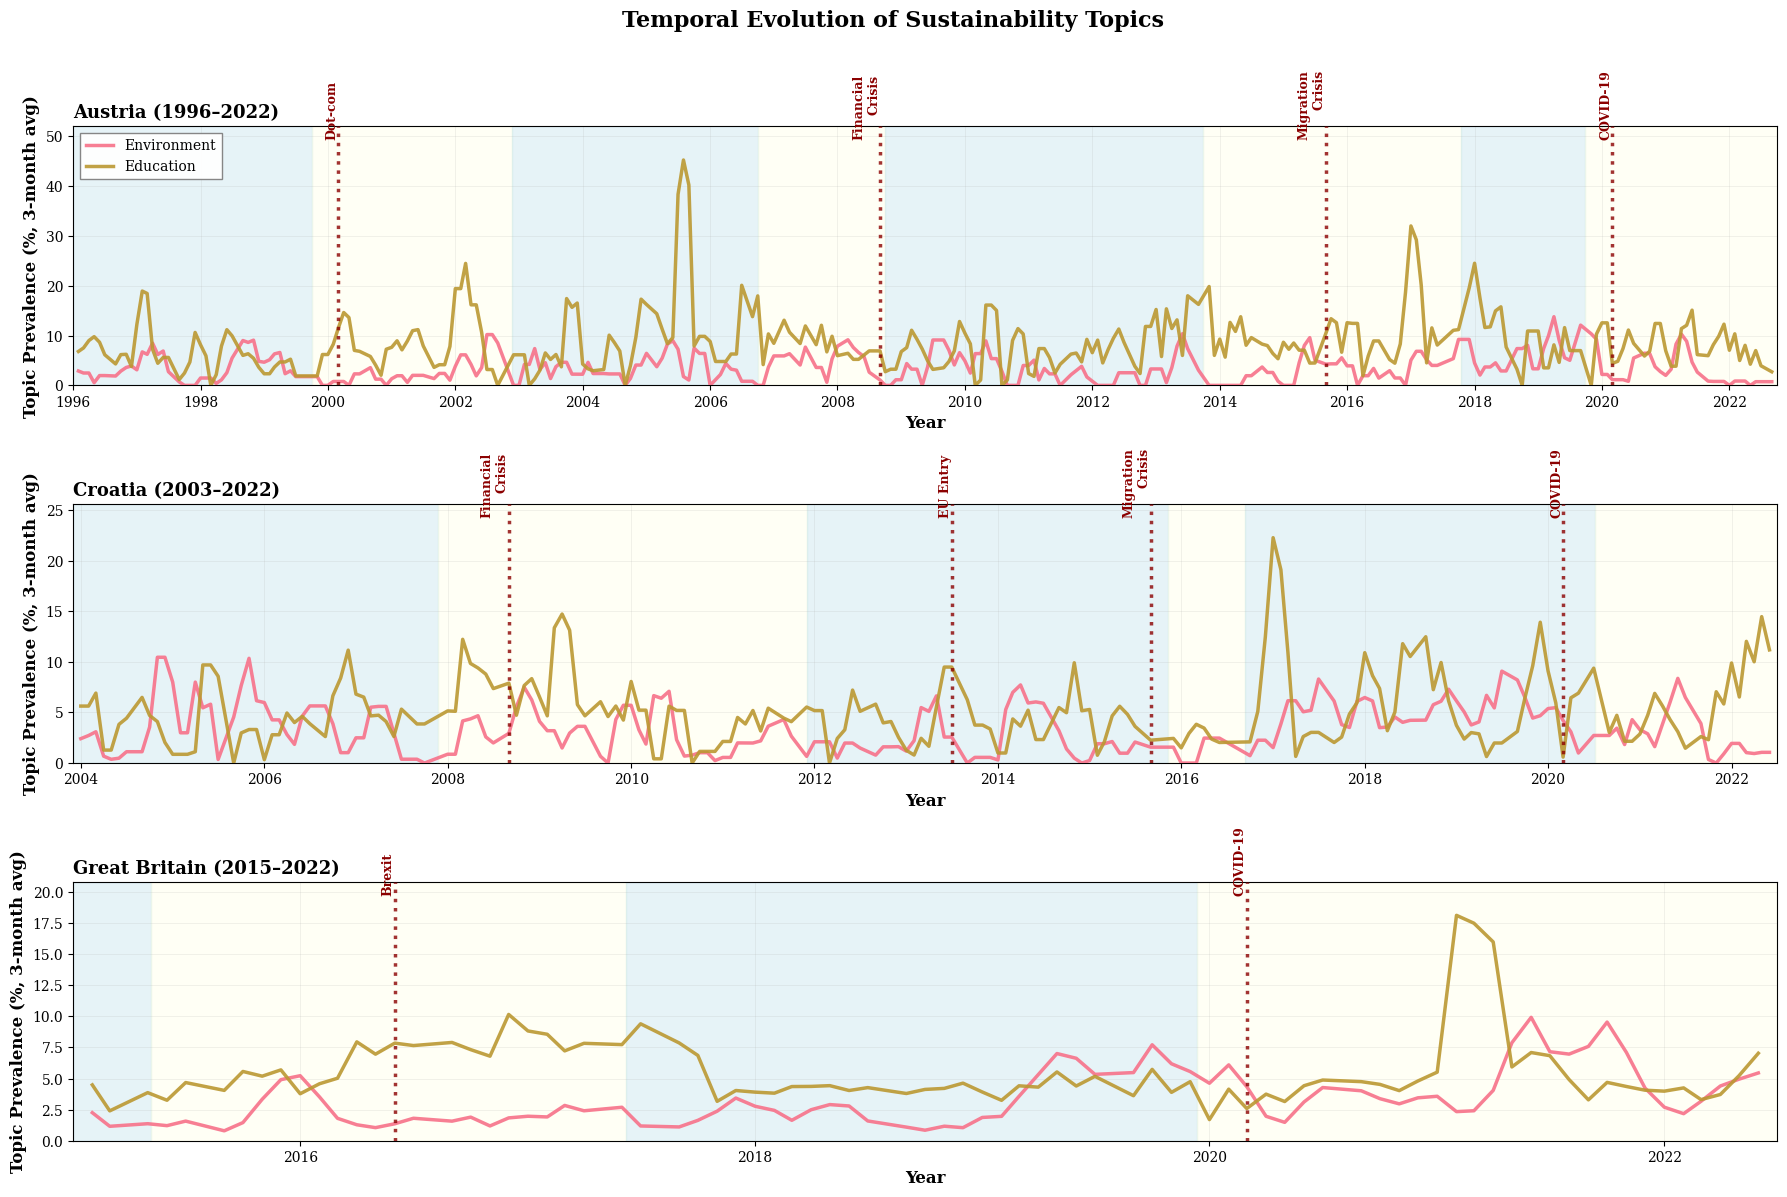

In [8]:
# Topic Prevalence Temporal Analysis - IMPROVED GROUPINGS

topic_temporal_data = LIWC_ALL[LIWC_ALL['Date'].notna()].copy()

# Define country-specific events
country_events = {
    'Austria': {
        '2000-03': 'Dot-com',
        '2008-09': 'Financial\nCrisis',
        '2015-09': 'Migration\nCrisis',
        '2020-03': 'COVID-19'
    },
    'Croatia': {
        '2008-09': 'Financial\nCrisis',
        '2013-07': 'EU Entry',
        '2015-09': 'Migration\nCrisis',
        '2020-03': 'COVID-19'
    },
    'Great Britain': {
        '2016-06': 'Brexit',
        '2020-03': 'COVID-19'
    }
}

# Define election dates
election_dates = {
    'Austria': [
        '1999-10-03', '2002-11-24', '2006-10-01', '2008-09-28',
        '2013-09-29', '2017-10-15', '2019-09-29'
    ],
    'Croatia': [
        '2003-11-23', '2007-11-25', '2011-12-04', '2015-11-08',
        '2016-09-11', '2020-07-05'
    ],
    'Great Britain': [
        '2001-06-07', '2005-05-05', '2010-05-06', '2015-05-07',
        '2017-06-08', '2019-12-12'
    ]
}

# IMPROVED topic groupings (policy domains)
topic_groups = {
    'Economic': ['Macroeconomics', 'Health'],
    'Security': ['Defense', 'International Affairs'],
    'Social': ['Social Welfare', 'Immigration'],
    'Sustainability': ['Environment', 'Education']
}

countries = sorted(topic_temporal_data['Country'].unique())

# Calculate monthly topic proportions
country_monthly_topics = {}
for country in countries:
    country_data = topic_temporal_data[topic_temporal_data['Country'] == country].copy()
    country_data['YearMonth'] = country_data['Date'].dt.to_period('M')
    
    month_counts = country_data['YearMonth'].value_counts()
    sufficient_months = month_counts[month_counts >= 5].index
    country_data = country_data[country_data['YearMonth'].isin(sufficient_months)]
    
    monthly_topic_data = country_data.groupby(['YearMonth', 'Our_Topic']).size().unstack(fill_value=0)
    monthly_topic_props = monthly_topic_data.div(monthly_topic_data.sum(axis=1), axis=0) * 100
    monthly_topic_props.index = monthly_topic_props.index.to_timestamp()
    
    # Apply 3-month rolling average
    monthly_topic_smooth = monthly_topic_props.rolling(window=3, center=True).mean()
    country_monthly_topics[country] = monthly_topic_smooth

# Create four separate figures
for fig_name, key_topics in topic_groups.items():
    fig, axes = plt.subplots(3, 1, figsize=(18, 12))
    fig.suptitle(f'Temporal Evolution of {fig_name} Topics', 
                fontsize=16, fontweight='bold', y=0.995)
    
    for idx, country in enumerate(countries):
        ax = axes[idx]
        
        monthly_props = country_monthly_topics[country]
        
        # Keep only available topics
        available_topics = [t for t in key_topics if t in monthly_props.columns]
        monthly_props_subset = monthly_props[available_topics]
        
        if len(monthly_props_subset) == 0 or len(available_topics) == 0:
            continue
        
        # Calculate y-axis limits
        y_min = 0
        y_max = monthly_props_subset.max().max()
        y_padding = y_max * 0.15
        
        # Add electoral period shading
        elections = [pd.to_datetime(d) for d in election_dates.get(country, [])]
        data_start = monthly_props_subset.index.min()
        data_end = monthly_props_subset.index.max()
        elections_in_range = [e for e in elections if e >= data_start and e <= data_end]
        
        if not elections_in_range or elections_in_range[0] > data_start:
            elections_in_range.insert(0, data_start)
        if elections_in_range[-1] < data_end:
            elections_in_range.append(data_end)
        
        # Shade periods
        for i in range(len(elections_in_range) - 1):
            start_date = elections_in_range[i]
            end_date = elections_in_range[i + 1]
            color = 'lightblue' if i % 2 == 0 else 'lightyellow'
            ax.axvspan(start_date, end_date, alpha=0.3, color=color, zorder=0)
        
        # Plot lines
        for topic in monthly_props_subset.columns:
            ax.plot(monthly_props_subset.index, monthly_props_subset[topic], 
                    linewidth=2.5, label=topic, alpha=0.9, zorder=3)
        
        # Add event markers
        events = country_events.get(country, {})
        for event_month, event in events.items():
            event_date = pd.to_datetime(event_month)
            if event_date >= monthly_props_subset.index.min() and event_date <= monthly_props_subset.index.max():
                ax.axvline(x=event_date, color='darkred', linestyle=':', alpha=0.8, 
                          linewidth=2.5, zorder=4)
                ax.text(event_date, y_max + y_padding * 0.6, event, 
                       rotation=90, va='bottom', ha='right', fontsize=9, 
                       color='darkred', fontweight='bold', zorder=5)
        
        # Formatting
        ax.set_xlabel('Year', fontweight='bold', fontsize=12)
        ax.set_ylabel('Topic Prevalence (%, 3-month avg)', fontweight='bold', fontsize=12)
        
        date_range = f"{monthly_props_subset.index.min().strftime('%Y')}–{monthly_props_subset.index.max().strftime('%Y')}"
        ax.set_title(f'{country} ({date_range})', 
                    fontweight='bold', loc='left', fontsize=13)
        ax.grid(True, alpha=0.25, linewidth=0.5, zorder=1)
        
        # Format x-axis
        import matplotlib.dates as mdates
        ax.xaxis.set_major_locator(mdates.YearLocator(2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        
        ax.set_xlim(monthly_props_subset.index.min(), monthly_props_subset.index.max())
        ax.set_ylim(y_min, y_max + y_padding)
        
        # Legend
        if idx == 0:
            ax.legend(loc='upper left', ncol=1, fontsize=10, framealpha=0.95, 
                     edgecolor='gray', fancybox=False)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    fig_suffix = fig_name.lower()
    plt.savefig(os.path.join(output_dir, f'fig_topic_prevalence_{fig_suffix}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()

## Topic Distribution Differences Analysis

Comparing topic distribution differences between our classification and reference labels (human labels for GB/HR, ParlaCAP labels for AT), excluding 'Other' and 'Mix' topics.

In [ ]:
def compare_topic_differences(df, our_col, comparison_col, dataset_name, exclude_topics=['Other', 'Mix'], use_counts=False):
    """Compare distribution differences between our topics and comparison topics (human labels or ParlaCAP)"""
    
    # Remove missing data
    clean_df = df.dropna(subset=[our_col, comparison_col])
    
    # Exclude specified topics
    for topic in exclude_topics:
        clean_df = clean_df[(clean_df[our_col] != topic) & (clean_df[comparison_col] != topic)]
    
    if use_counts:
        # Use raw counts for small datasets
        our_dist = clean_df[our_col].value_counts()
        comparison_dist = clean_df[comparison_col].value_counts()
        y_label = 'Count Difference'
        title_suffix = '(Our Classification - Reference Labels, Raw Counts)'
    else:
        # Use percentages for large datasets
        our_dist = clean_df[our_col].value_counts(normalize=True) * 100
        comparison_dist = clean_df[comparison_col].value_counts(normalize=True) * 100
        y_label = 'Percentage Point Difference'
        title_suffix = '(Our Classification - Reference Labels, %)'
    
    # Combine into comparison DataFrame
    comparison_df = pd.DataFrame({
        'Our_Classification': our_dist,
        'Comparison_Label': comparison_dist
    }).fillna(0)
    
    # Calculate difference
    diff = comparison_df['Our_Classification'] - comparison_df['Comparison_Label']
    
    # Sort by absolute difference
    diff = diff.reindex(diff.abs().sort_values(ascending=True).index)
    
    # Plot difference
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in diff]
    diff.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_title(f'{dataset_name}: Topic Distribution Difference\n{title_suffix}', fontsize=14)
    ax.set_xlabel(y_label, fontsize=12)
    ax.set_ylabel('Topics', fontsize=12)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'topic_diff_{dataset_name.lower().replace(" ", "_")}.png'), 
               dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top differences
    print(f"\n📈 {dataset_name} - Top 5 Distribution Differences:")
    top_diffs = diff.abs().nlargest(5)
    for topic, abs_diff in top_diffs.items():
        actual_diff = diff[topic]
        direction = "over-represented" if actual_diff > 0 else "under-represented"
        if use_counts:
            print(f"  {topic}: {actual_diff:+.0f} speeches ({direction})")
        else:
            print(f"  {topic}: {actual_diff:+.2f}% ({direction})")
    
    print(f"\n📊 Total categories compared: {len(diff)}")
    if use_counts:
        print(f"📊 Mean absolute difference: {diff.abs().mean():.1f} speeches")
        print(f"📊 Total speeches analyzed: {len(clean_df):,}")
    else:
        print(f"📊 Mean absolute difference: {diff.abs().mean():.2f}%")
    
    return diff

print("="*60)
print("TOPIC DISTRIBUTION DIFFERENCE ANALYSIS")
print("="*60)

TOPIC DISTRIBUTION DIFFERENCE ANALYSIS



🇬🇧 GREAT BRITAIN - vs Human Labels
------------------------------------------------------------
Speeches with human labels: 876


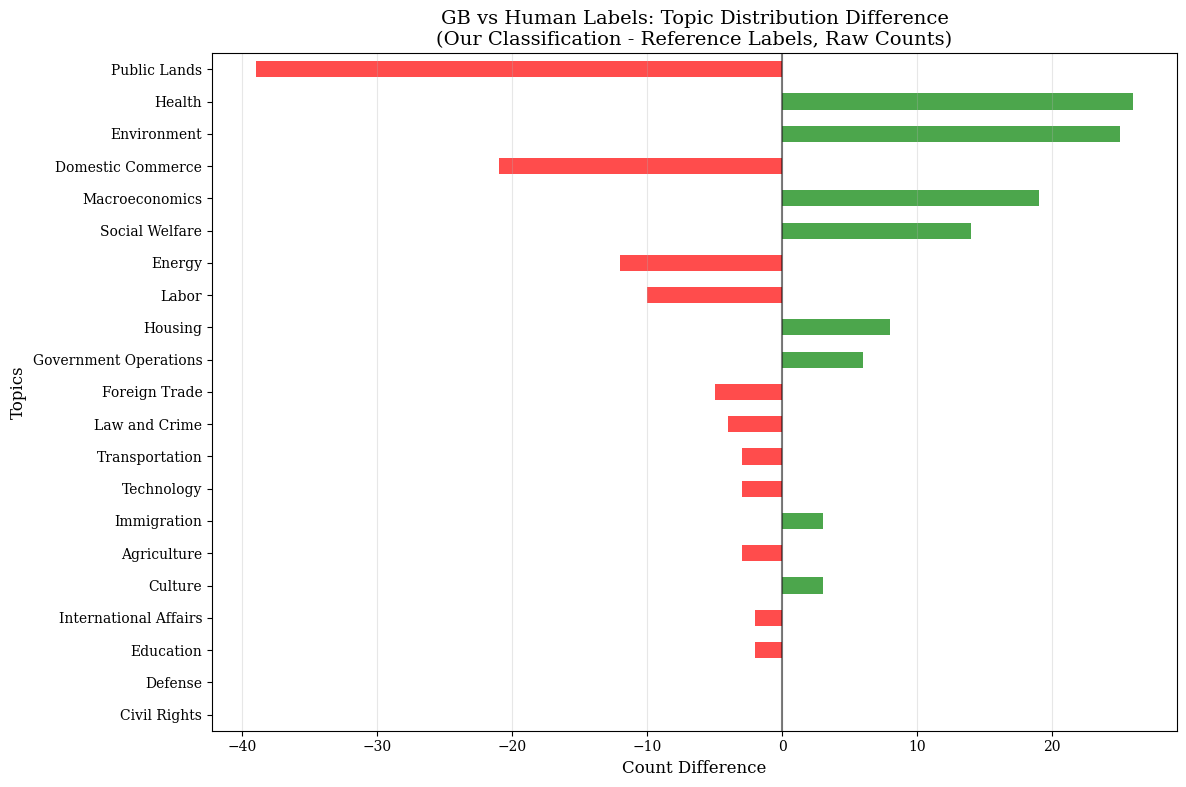


📈 GB vs Human Labels - Top 5 Distribution Differences:
  Public Lands: -39 speeches (under-represented)
  Health: +26 speeches (over-represented)
  Environment: +25 speeches (over-represented)
  Domestic Commerce: -21 speeches (under-represented)
  Macroeconomics: +19 speeches (over-represented)

📊 Total categories compared: 21
📊 Mean absolute difference: 9.9 speeches
📊 Total speeches analyzed: 671


In [ ]:
# GB: Compare against human labels (use raw counts)
print("\n🇬🇧 GREAT BRITAIN - vs Human Labels")
print("-"*60)

GB_with_human = GB.dropna(subset=['True_label'])
print(f"Speeches with human labels: {len(GB_with_human):,}")

gb_diff_human = compare_topic_differences(
    GB_with_human, 
    'topic_consensus', 
    'True_label', 
    'GB vs Human Labels',
    exclude_topics=['Other', 'Mix'],
    use_counts=True
)


🇭🇷 CROATIA - vs Human Labels
------------------------------------------------------------
Speeches with human labels: 869


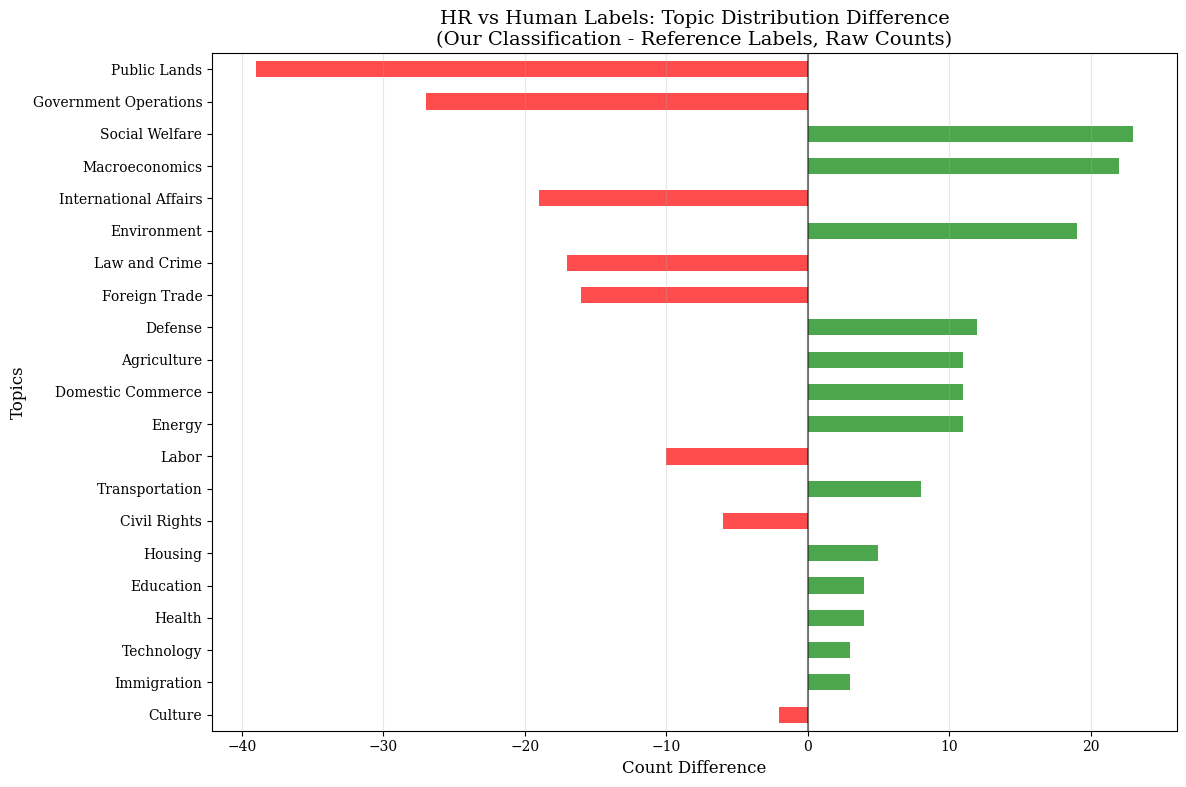


📈 HR vs Human Labels - Top 5 Distribution Differences:
  Public Lands: -39 speeches (under-represented)
  Government Operations: -27 speeches (under-represented)
  Social Welfare: +23 speeches (over-represented)
  Macroeconomics: +22 speeches (over-represented)
  Environment: +19 speeches (over-represented)

📊 Total categories compared: 21
📊 Mean absolute difference: 13.0 speeches
📊 Total speeches analyzed: 699


In [ ]:
# HR: Compare against human labels (use raw counts)
print("\n🇭🇷 CROATIA - vs Human Labels")
print("-"*60)

HR_with_human = HR.dropna(subset=['True_label'])
print(f"Speeches with human labels: {len(HR_with_human):,}")

hr_diff_human = compare_topic_differences(
    HR_with_human, 
    'topic_consensus', 
    'True_label', 
    'HR vs Human Labels',
    exclude_topics=['Other', 'Mix'],
    use_counts=True
)


🇦🇹 AUSTRIA - vs ParlaCAP Labels
------------------------------------------------------------
Total speeches: 231,759


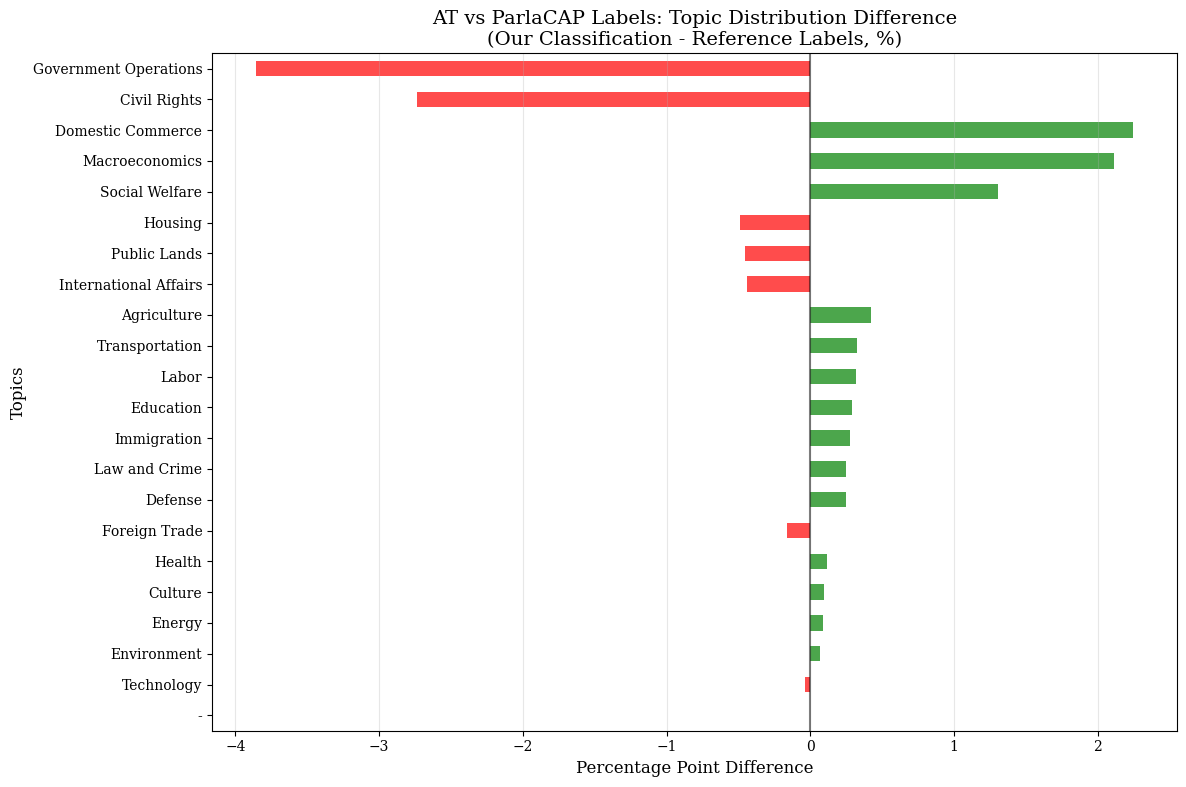


📈 AT vs ParlaCAP Labels - Top 5 Distribution Differences:
  Government Operations: -3.86% (under-represented)
  Civil Rights: -2.73% (under-represented)
  Domestic Commerce: +2.25% (over-represented)
  Macroeconomics: +2.11% (over-represented)
  Social Welfare: +1.31% (over-represented)

📊 Total categories compared: 22
📊 Mean absolute difference: 0.74%


In [ ]:
# AT: Compare against ParlaCAP labels (use percentages - large dataset)
print("\n🇦🇹 AUSTRIA - vs ParlaCAP Labels")
print("-"*60)
print(f"Total speeches: {len(AT):,}")

at_diff_parlacap = compare_topic_differences(
    AT, 
    'topic_consensus', 
    'Topic', 
    'AT vs ParlaCAP Labels',
    exclude_topics=['Other', 'Mix'],
    use_counts=False
)

## Summary: Topic Distribution Differences

**Key Findings:**
- GB and HR are compared against human-annotated ground truth labels
- AT is compared against ParlaCAP model predictions (no human labels available)
- 'Other' and 'Mix' topics are excluded from all comparisons
- Green bars indicate topics we classify more frequently than reference
- Red bars indicate topics we classify less frequently than reference